<a href="https://colab.research.google.com/github/gi1no/Education/blob/main/ThinkStats/chap06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The third edition of *Think Stats* is available now from [Bookshop.org](https://bookshop.org/a/98697/9781098190255) and [Amazon](https://amzn.to/42lmxwu) (those are affiliate links). If you are enjoying the free, online version, consider [buying me a coffee](https://buymeacoffee.com/allendowney).

# Probability Density Functions

In the previous chapter, we modeled data with theoretical distributions including the binomial, Poisson, exponential, and normal distributions.

The binomial and Poisson distributions are **discrete**, which means that the outcomes have to be distinct or separate elements, like an integer number of hits and misses, or goals scored.
In a discrete distribution, each outcome is associated with a probability mass.

The exponential and normal distribution are **continuous**, which means the outcomes can be at any point in a range of possible values.
In a continuous distribution, each outcome is associated with a **probability density**.
Probability density is an abstract idea, and many people find it difficult at first, but we'll take it one step at a time.
As a first step, let's think again about comparing distributions.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap06.ipynb).

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

Downloaded thinkstats.py


In [3]:
try:
    import empiricaldist
except ImportError:
    %pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.9.0-py3-none-any.whl size=14296 sha256=7df14ebb3f7828de8947234186502cd75e8aff7a94cafe02cdfd5ee8236e9954
  Stored in directory: /root/.cache/pip/wheels/96/04/f1/a934ef1f5f3db621dc39566b2c7de45b8c6916044be6a9c9ac
Successfully built empiricaldist


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

## Comparing Distributions

In the previous chapter, when we compared discrete distributions, we used a bar plot to show their probability mass functions (PMFs).
When we compared continuous distributions, we used a line plot to show their cumulative distribution functions (CDFs).

For the discrete distributions, we could also have used CDFs.
For example, here's the PMF of a Poisson distribution with `lam=2.2`, which is a good model for the distribution of household size in the NSFG data.

The following cells download the data files and install `statadict`, which we need to read the data.

In [5]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemResp.dat.gz")

Downloaded nsfg.py
Downloaded 2002FemResp.dct
Downloaded 2002FemResp.dat.gz


In [6]:
try:
    import statadict
except ImportError:
    %pip install statadict

We can use `read_fem_resp` to read the respondent data file.

In [7]:
from nsfg import read_fem_resp

resp = read_fem_resp()

Next we'll select household sizes for people 25 and older.

In [8]:
older = resp.query("age >= 25")
num_family = older["numfmhh"]

And make a `Pmf` that represents the distribution of responses.

In [9]:
from empiricaldist import Pmf

pmf_family = Pmf.from_seq(num_family, name="data")

Here's another `Pmf` that represents a Poisson distribution with the same mean.

In [10]:
from thinkstats import poisson_pmf

lam = 2.2
ks = np.arange(11)
ps = poisson_pmf(ks, lam)

pmf_poisson = Pmf(ps, ks, name="Poisson model")

And here's how the distribution of the data compares to the Poisson model.

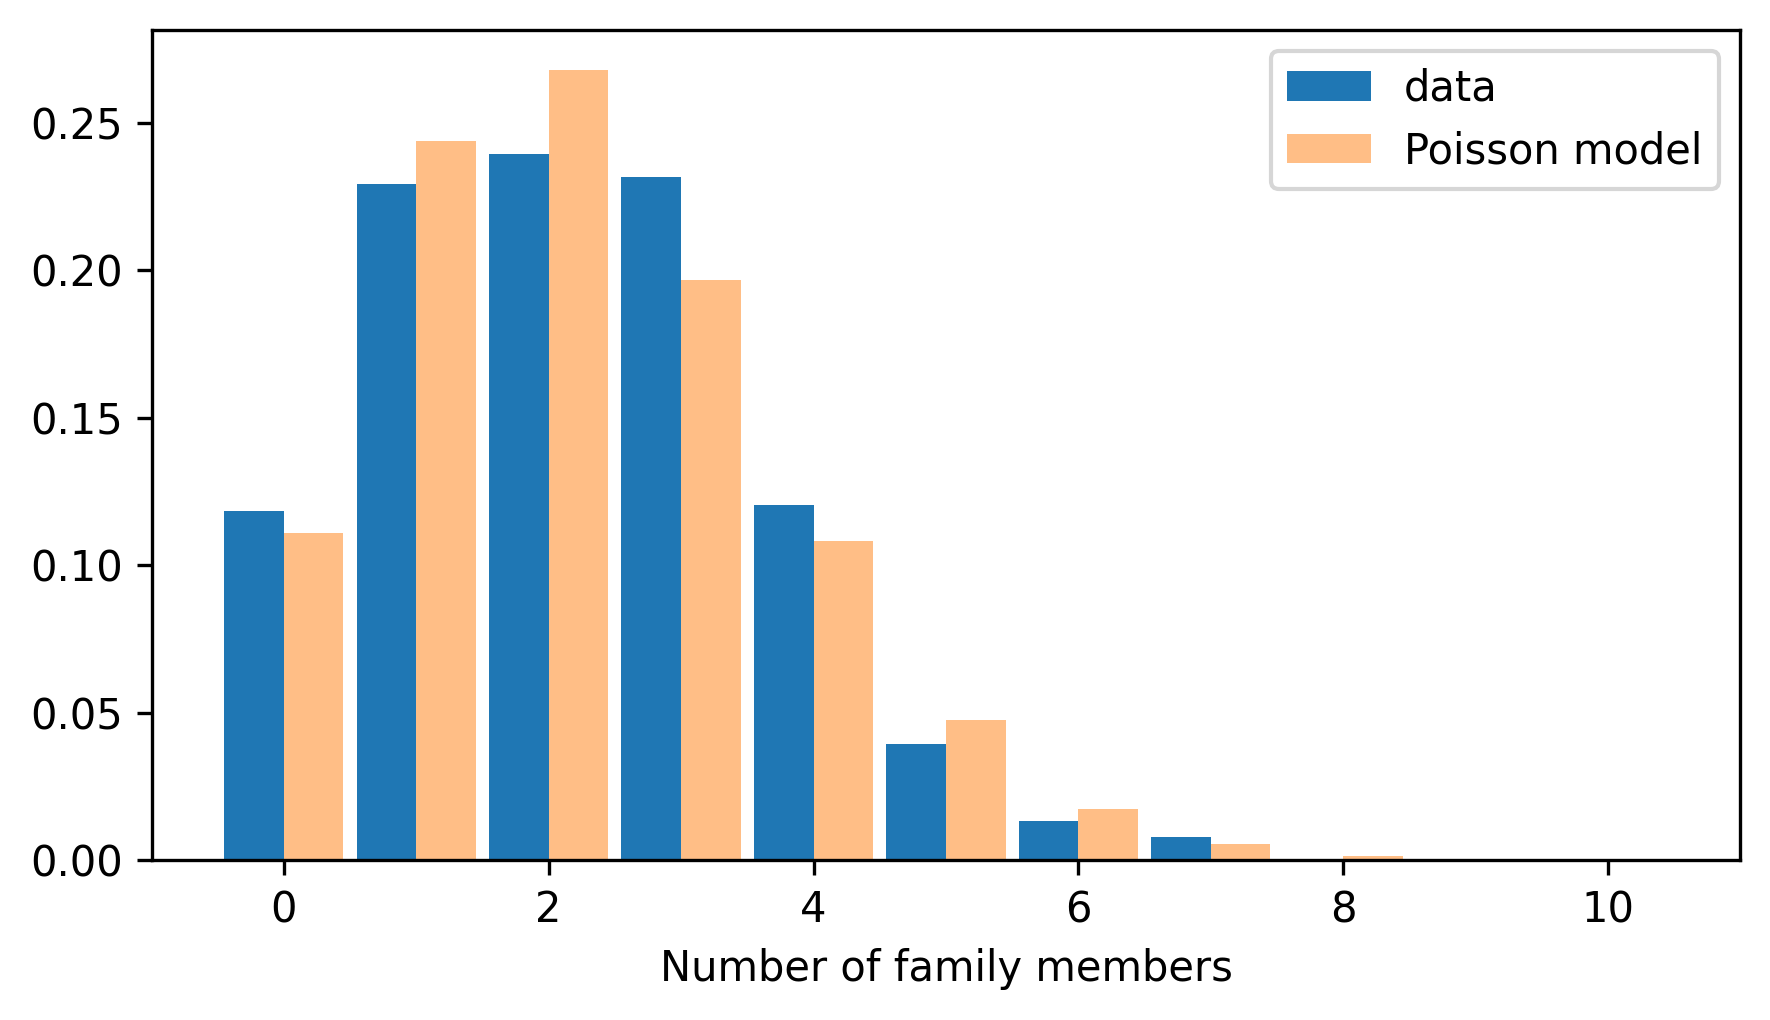

In [11]:
from thinkstats import two_bar_plots

two_bar_plots(pmf_family, pmf_poisson)
decorate(xlabel="Number of family members")

Comparing the PMFs, we can see that the model fits the data well, but with some deviations.

To get a sense of how substantial those deviations are, it can be helpful to compare CDFs.
We can use `make_cdf` to compute the CDFs of the data and the model.

In [12]:
cdf_family = pmf_family.make_cdf()
cdf_poisson = pmf_poisson.make_cdf()

Here's what they look like.

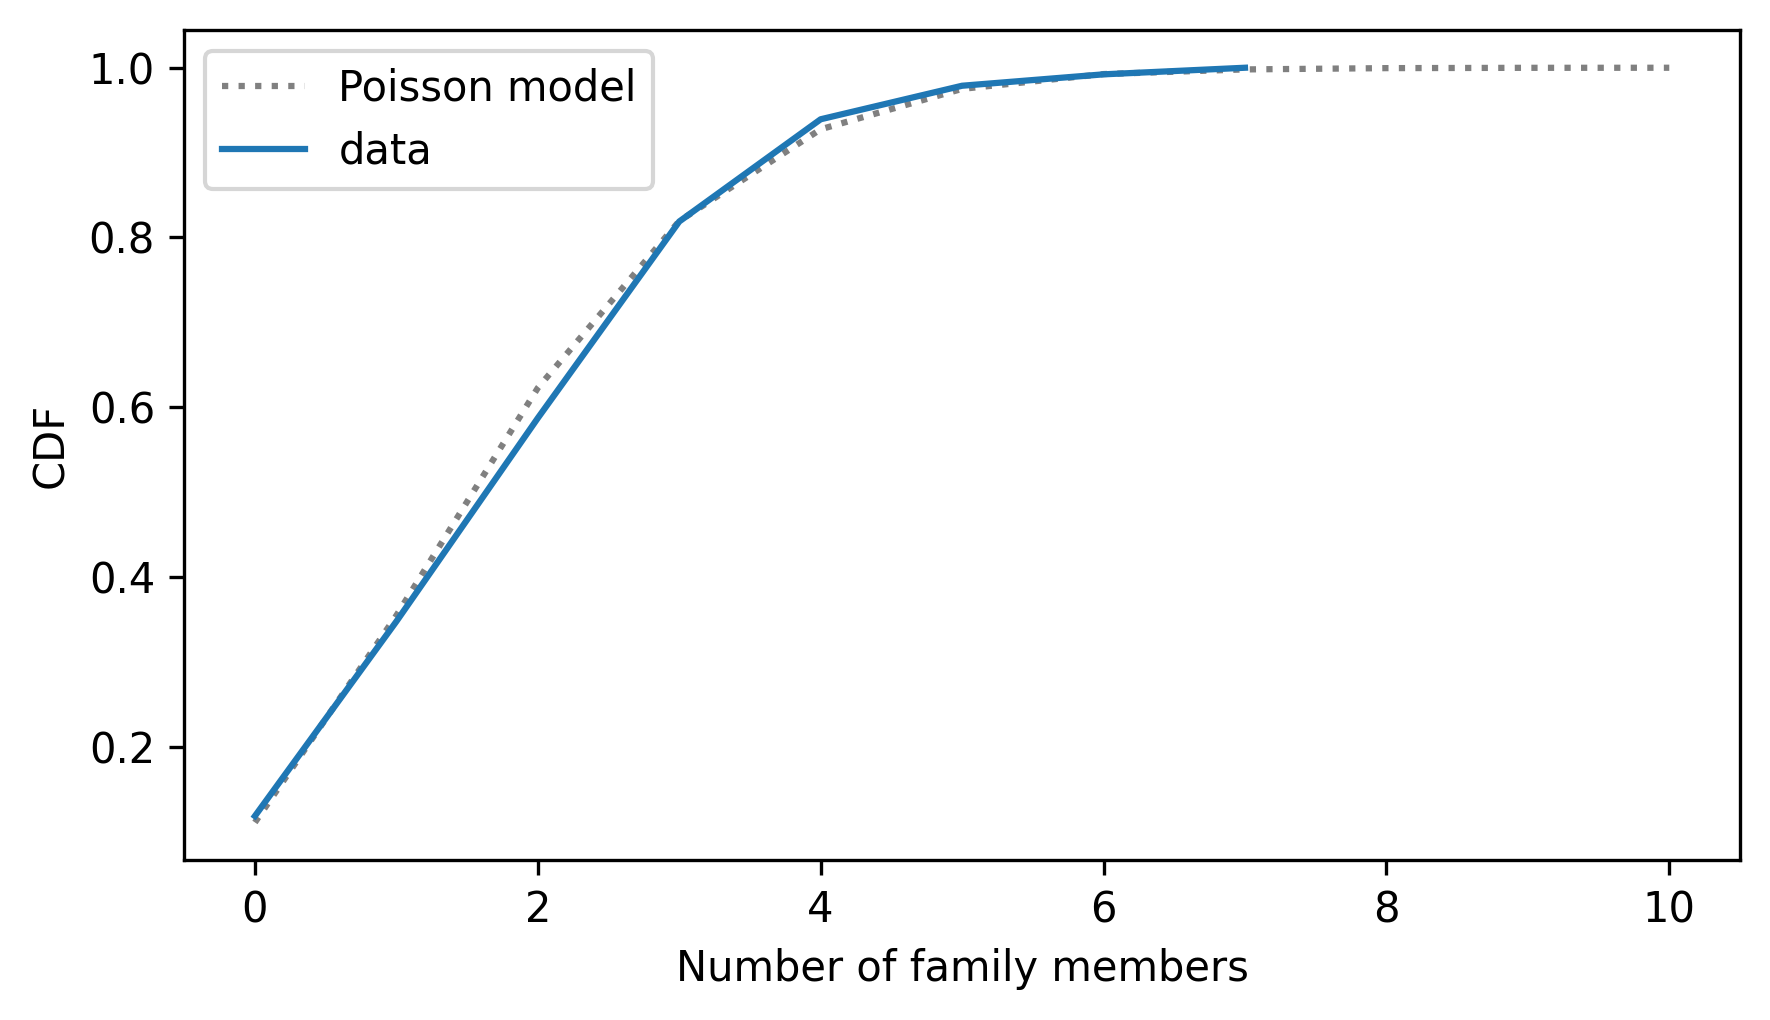

In [13]:
from thinkstats import two_cdf_plots

two_cdf_plots(cdf_poisson, cdf_family)
decorate(xlabel="Number of family members")

When we compare CDFs, the deviations are less prominent, but we can see where and how the distributions differ.
PMFs tend to emphasize small differences -- sometimes CDFs provide a better sense of the big picture.

CDFs also work well with continuous data. As an example, let's look at the distribution of birth weights again, which is in the NSFG pregnancy file.

In [14]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

Downloaded 2002FemPreg.dct
Downloaded 2002FemPreg.dat.gz


In [15]:
from nsfg import read_fem_preg

preg = read_fem_preg()
birth_weights = preg["totalwgt_lb"].dropna()

Here is the code we used in the previous chapter to fit a normal model to the data.

In [16]:
from scipy.stats import trimboth
from thinkstats import make_normal_model

trimmed = trimboth(birth_weights, 0.01)
cdf_model = make_normal_model(trimmed)

And here's the distribution of the data compared to the normal model.

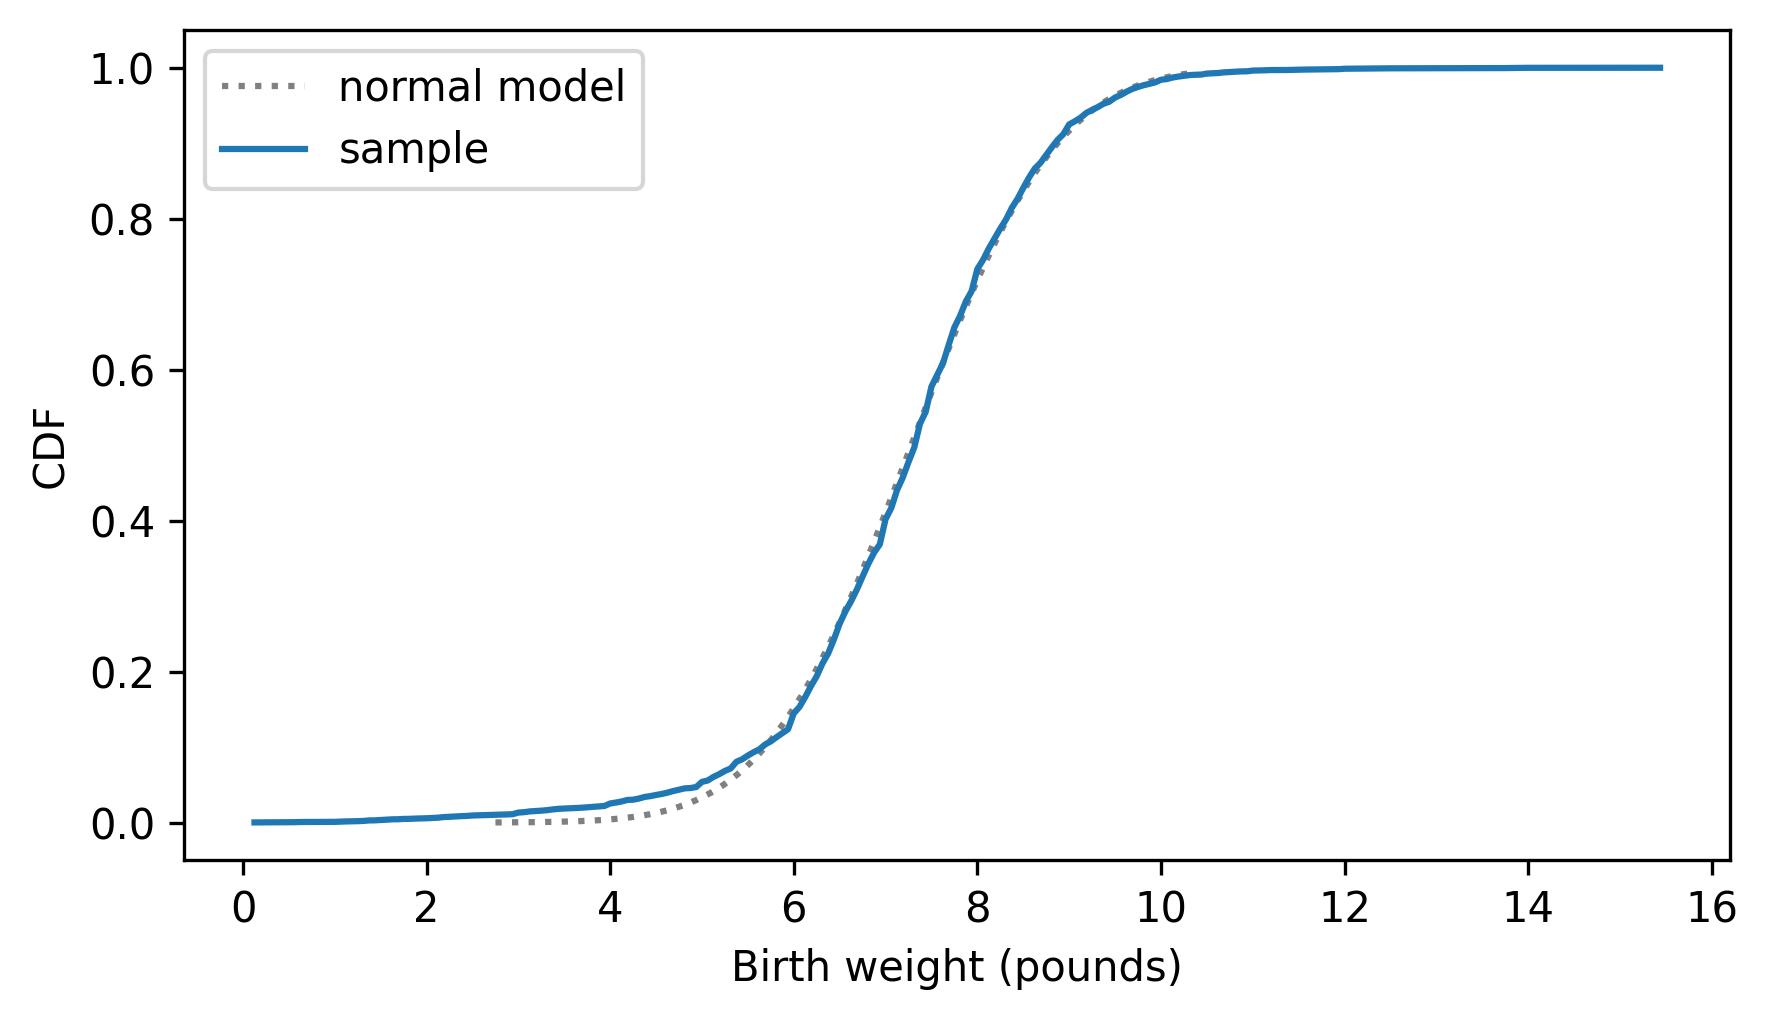

In [17]:
from empiricaldist import Cdf

cdf_birth_weight = Cdf.from_seq(birth_weights, name="sample")
two_cdf_plots(cdf_model, cdf_birth_weight, xlabel="Birth weight (pounds)")

As we saw in the previous chapter, the normal model fits the data well except in the range of the lightest babies.

In my opinion, CDFs are usually the best way to compare data to a model.
But for audiences that are not familiar with CDFs, there is one more option: probability density functions.

## Probability Density

We'll start with the **probability density function (PDF)** of the normal distribution, which computes the density for the quantities, `xs`, given `mu` and `sigma`.

In [18]:
def normal_pdf(xs, mu, sigma):
    """Evaluates the normal probability density function."""
    z = (xs - mu) / sigma
    return np.exp(-(z**2) / 2) / sigma / np.sqrt(2 * np.pi)

For `mu` and `sigma` we'll use the mean and standard deviation of the trimmed birth weights.

In [19]:
m, s = np.mean(trimmed), np.std(trimmed)

Now we'll evaluate `normal_pdf` for a range of weights.

In [20]:
low = m - 4 * s
high = m + 4 * s
qs = np.linspace(low, high, 201)
ps = normal_pdf(qs, m, s)

And plot it.

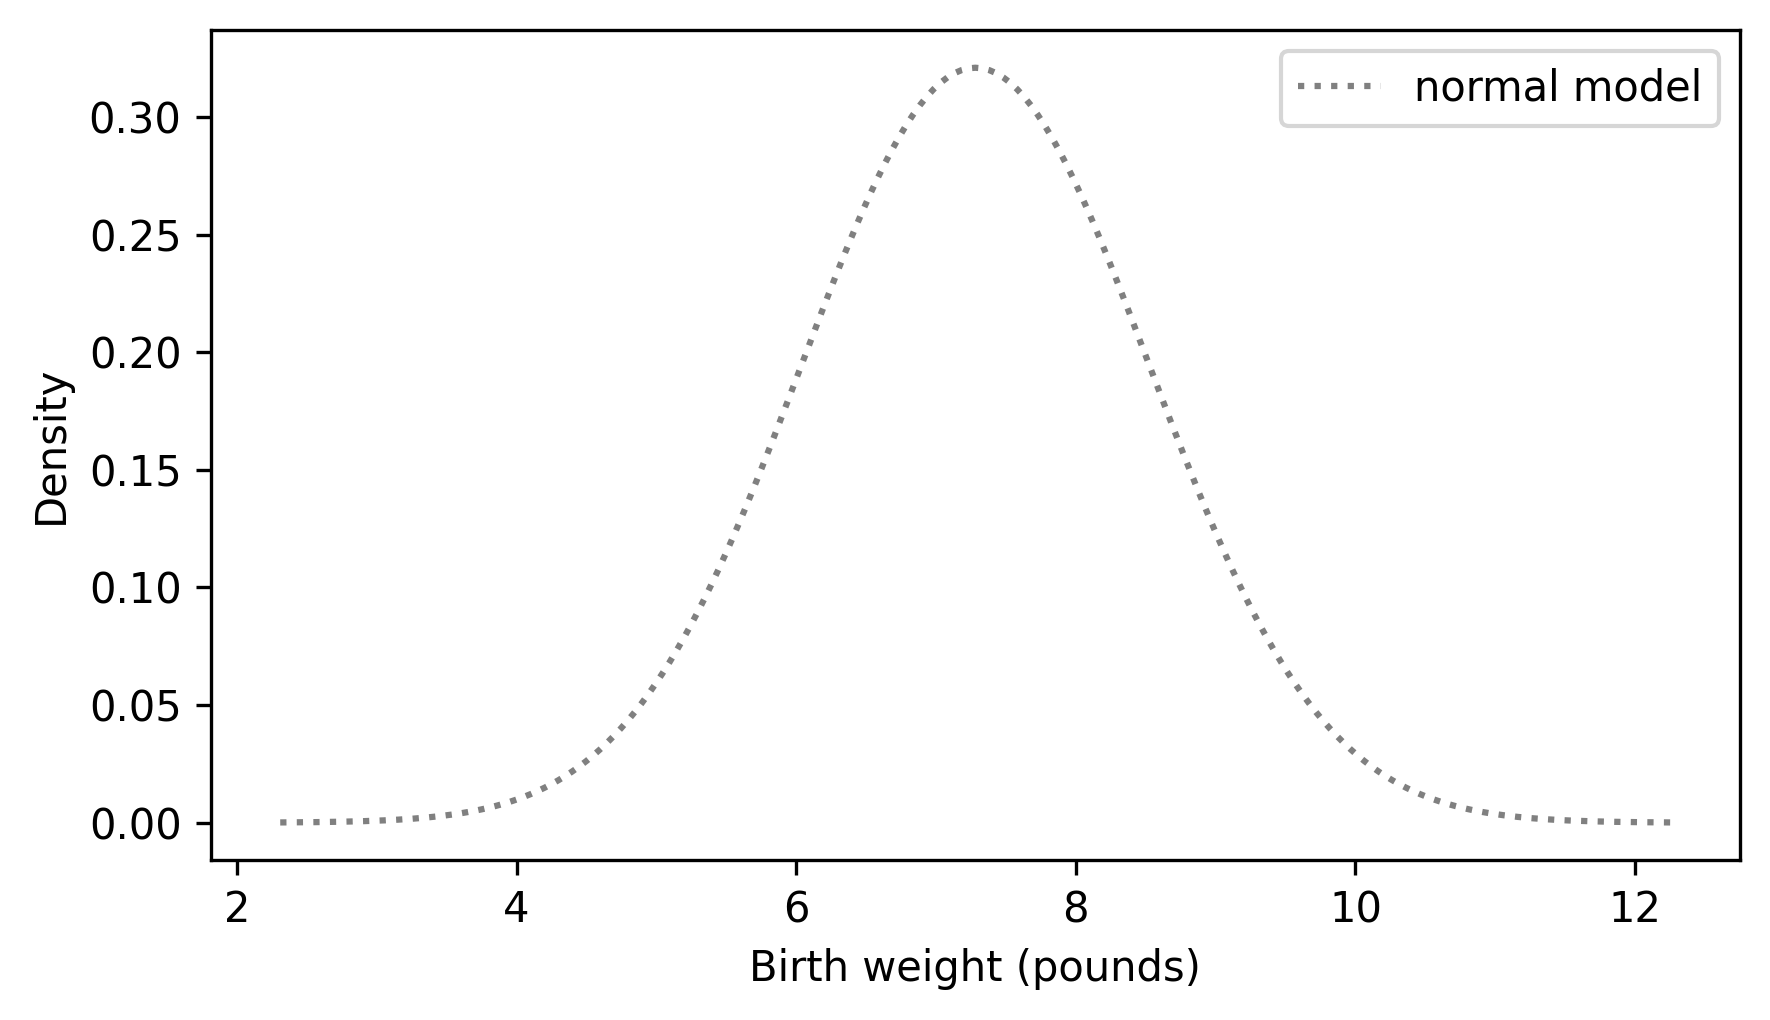

In [21]:
plt.plot(qs, ps, label="normal model", ls=":", color="gray")
decorate(xlabel="Birth weight (pounds)", ylabel="Density")

The result looks like a bell curve, which is characteristic of the normal distribution.

When we evaluate `normal_pdf`, the result is a probability density.
For example, here's the density function evaluated at the mean, which is where the density is highest.

In [22]:
normal_pdf(m, m, s)

np.float64(0.32093416297880123)

By itself, a probability density doesn't mean much -- most importantly, it is *not* a probability.
It would be incorrect to say that the probability is 32% that a randomly-chosen birth weight equals `m`.
In fact, the probability that a birth weight is truly, exactly, and precisely equal to `m` -- or any other specific value -- is zero.

However, we can use the probability densities to compute the probability that an outcome falls in an interval between two values, by computing the area under the curve.

We could do that with the `normal_pdf` function, but it is more convenient to use the `NormalPdf` class, which is defined in the `thinkstats` module.
Here's how we create a `NormalPdf` object with the same mean and standard deviation as the birth weights in the NSFG dataset.

In [23]:
from thinkstats import NormalPdf

pdf_model = NormalPdf(m, s, name="normal model")
pdf_model

NormalPdf(7.280883100022579, 1.2430657948614345, name='normal model')

If we call this object like a function, it evaluates the normal PDF.

In [24]:
pdf_model(m)

np.float64(0.32093416297880123)

Now, to compute the area under the PDF, we can use the following function, which takes a `NormalPdf` object and the bounds of an interval, `low` and `high`.
It evaluates the normal PDF at equally-spaced quantities between `low` and `high`, and uses the SciPy function `simpson` to estimate the area under the curve (`simpson` is so named because it uses an algorithm called Simpson's method).

In [25]:
from scipy.integrate import simpson


def area_under(pdf, low, high):
    qs = np.linspace(low, high, 501)
    ps = pdf(qs)
    return simpson(y=ps, x=qs)

If we compute the area under the curve from the lowest to the highest point in the graph, the result is close to 1.

In [26]:
area_under(pdf_model, 2, 12)

np.float64(0.9999158086616793)

If we extend the interval from negative infinity to positive infinity, the total area is exactly 1.

If we start from 0 -- or any value far below the mean -- we can compute the fraction of birth weights less than or equal to 8.5 pounds.

In [27]:
area_under(pdf_model, 0, 8.5)

np.float64(0.8366380335513807)

You might recall that the "fraction less than or equal to a given value" is the definition of the CDF.
So we could compute the same result using the CDF of the normal distribution.

In [28]:
from scipy.stats import norm

norm.cdf(8.5, m, s)

np.float64(0.8366380358092718)

Similarly, we can use the area under the density curve to compute the fraction of birth weights between 6 and 8 pounds.

In [29]:
area_under(pdf_model, 6, 8)

np.float64(0.5671317752927691)

Or we can get the same result using the CDF to compute the fraction less than 8 and then subtracting off the fraction less than 6.

In [30]:
norm.cdf(8, m, s) - norm.cdf(6, m, s)

np.float64(0.5671317752921801)

So the CDF is the area under the curve of the PDF.
If you know calculus, another way to say the same thing is that the CDF is the integral of the PDF.
And conversely, the PDF is the derivative of the CDF.

(section_exponential_pdf)=
## The Exponential PDF

To get your head around probability density, it might help to see another example.
In the previous chapter, we used an exponential distribution to model the time until the first goal in a hockey game.
We used the following function to compute the exponential CDF, where `lam` is the rate in goals per unit of time.

In [31]:
def exponential_cdf(x, lam):
    """Compute the exponential CDF.

    x: float or sequence of floats
    lam: rate parameter

    returns: float or NumPy array of cumulative probability
    """
    return 1 - np.exp(-lam * x)

We can compute the PDF of the exponential distribution like this.

In [32]:
def exponential_pdf(x, lam):
    """Evaluates the exponential PDF.

    x: float or sequence of floats
    lam: rate parameter

    returns: float or NumPy array of probability density
    """
    return lam * np.exp(-lam * x)

`thinkstats` provides an `ExponentialPdf` object that uses this function to compute the exponential PDF.
We can use one to represent an exponential distribution with rate 6 goals per game.

In [33]:
from thinkstats import ExponentialPdf

lam = 6
pdf_expo = ExponentialPdf(lam, name="exponential model")
pdf_expo

ExponentialPdf(6, name='exponential model')

`ExponentialPdf` provides a `plot` function we can use to plot the PDF -- notice that the unit of time is games here, rather than seconds as in the previous chapter.

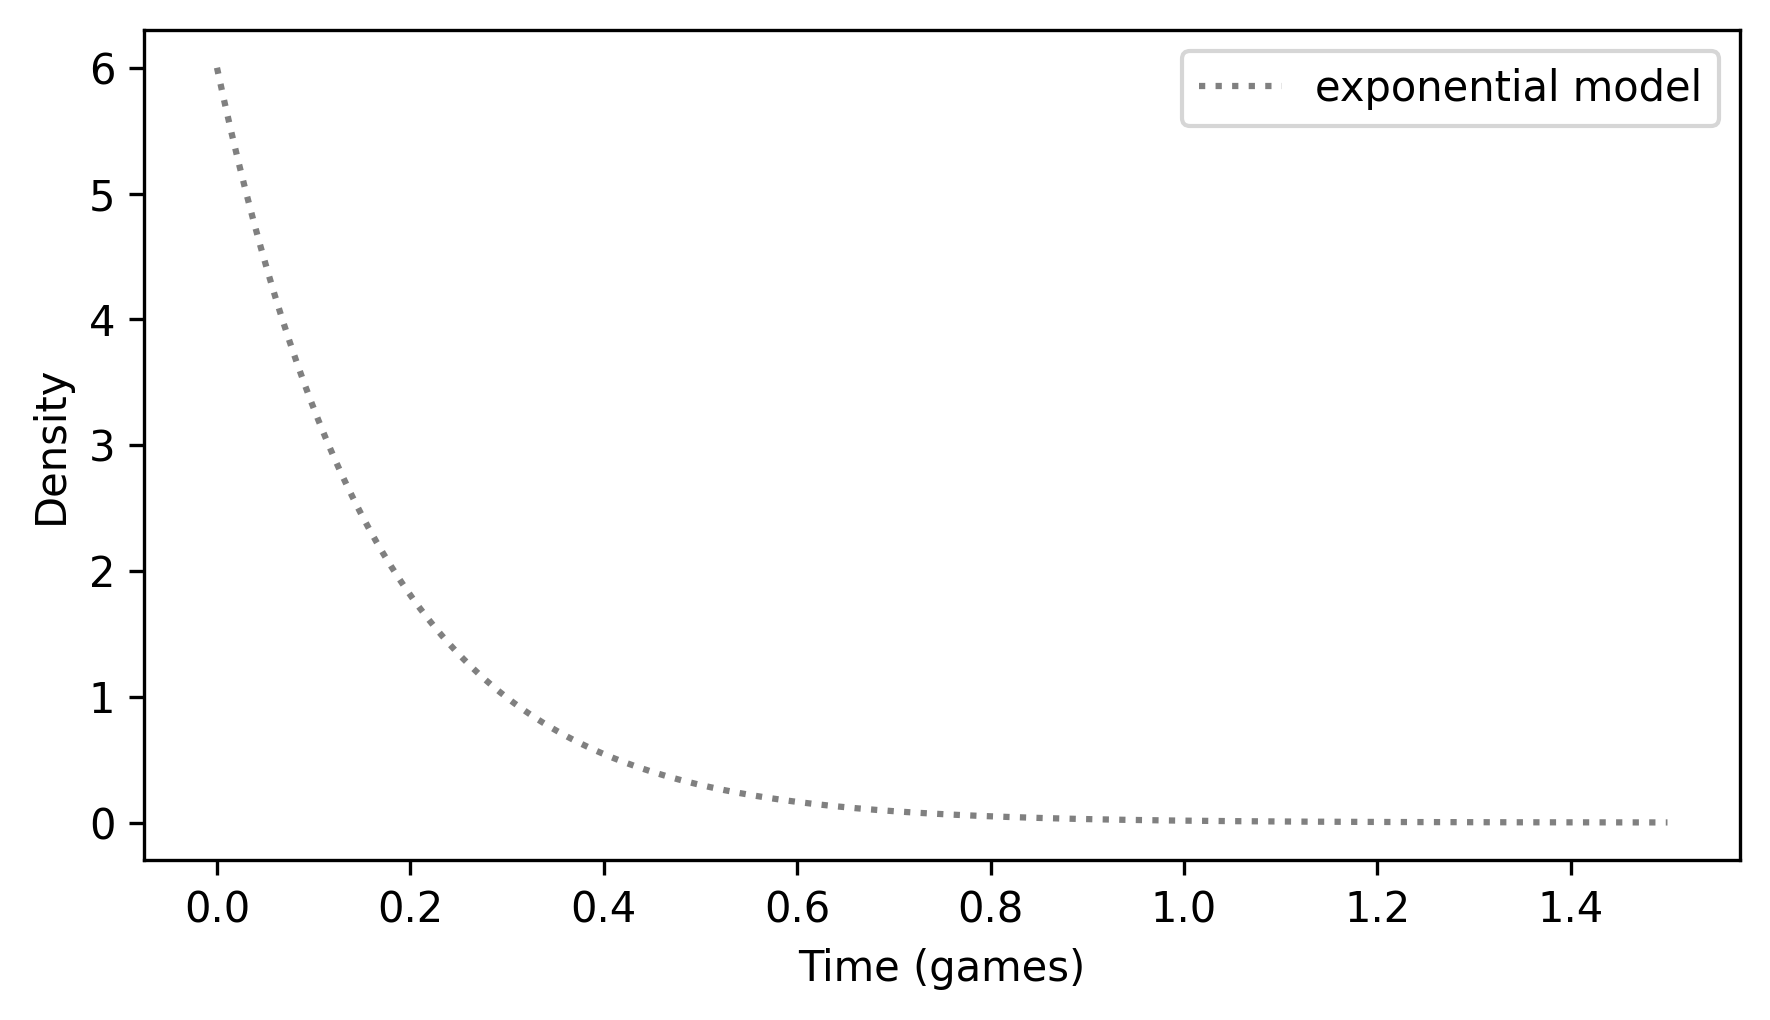

In [34]:
qs = np.linspace(0, 1.5, 201)
pdf_expo.plot(qs, ls=":", color="gray")
decorate(xlabel="Time (games)", ylabel="Density")

Looking at the y-axis, you might notice that some of these densities are greater than 1, which is a reminder that a probability density is not a probability.
But the area under a density curve is a probability, so it should never be greater than 1.

If we compute the area under this curve from 0 to 1.5 games, we can confirm that the result is close to 1.

In [35]:
area_under(pdf_expo, 0, 1.5)

np.float64(0.999876590779019)

If we extend the interval much farther, the result is slightly greater than 1, but that's because we're approximating the area numerically.
Mathematically, it is exactly 1, as we can confirm using the exponential CDF.

In [36]:
from thinkstats import exponential_cdf

exponential_cdf(7, lam)

np.float64(1.0)

We can use the area under the density curve to compute the probability of a goal during any interval.
For example, here is the probability of a goal during the first minute of a 60-minute game.

In [37]:
area_under(pdf_expo, 0, 1 / 60)

np.float64(0.09516258196404043)

We can compute the same result using the exponential CDF.

In [38]:
exponential_cdf(1 / 60, lam)

np.float64(0.09516258196404048)

In summary, if we evaluate a PDF, the result is a probability density -- which is not a probability.
However, if we compute the area under the PDF, the result is the probability that a quantity falls in an interval.
Or we can find the same probability by evaluating the CDF at the beginning and end of the interval and computing the difference.

## Comparing PMFs and PDFs

It is a common error to compare the PMF of a sample with the PDF of a theoretical model.
For example, suppose we want to compare the distribution of birth weights to a normal model.
Here's a `Pmf` that represents the distribution of the data.

In [39]:
pmf_birth_weight = Pmf.from_seq(birth_weights, name="data")

And we already have `pdf_model`, which represents the PDF of the normal distribution with the same mean and standard deviation.
Here's what happens if we plot them on the same axis.

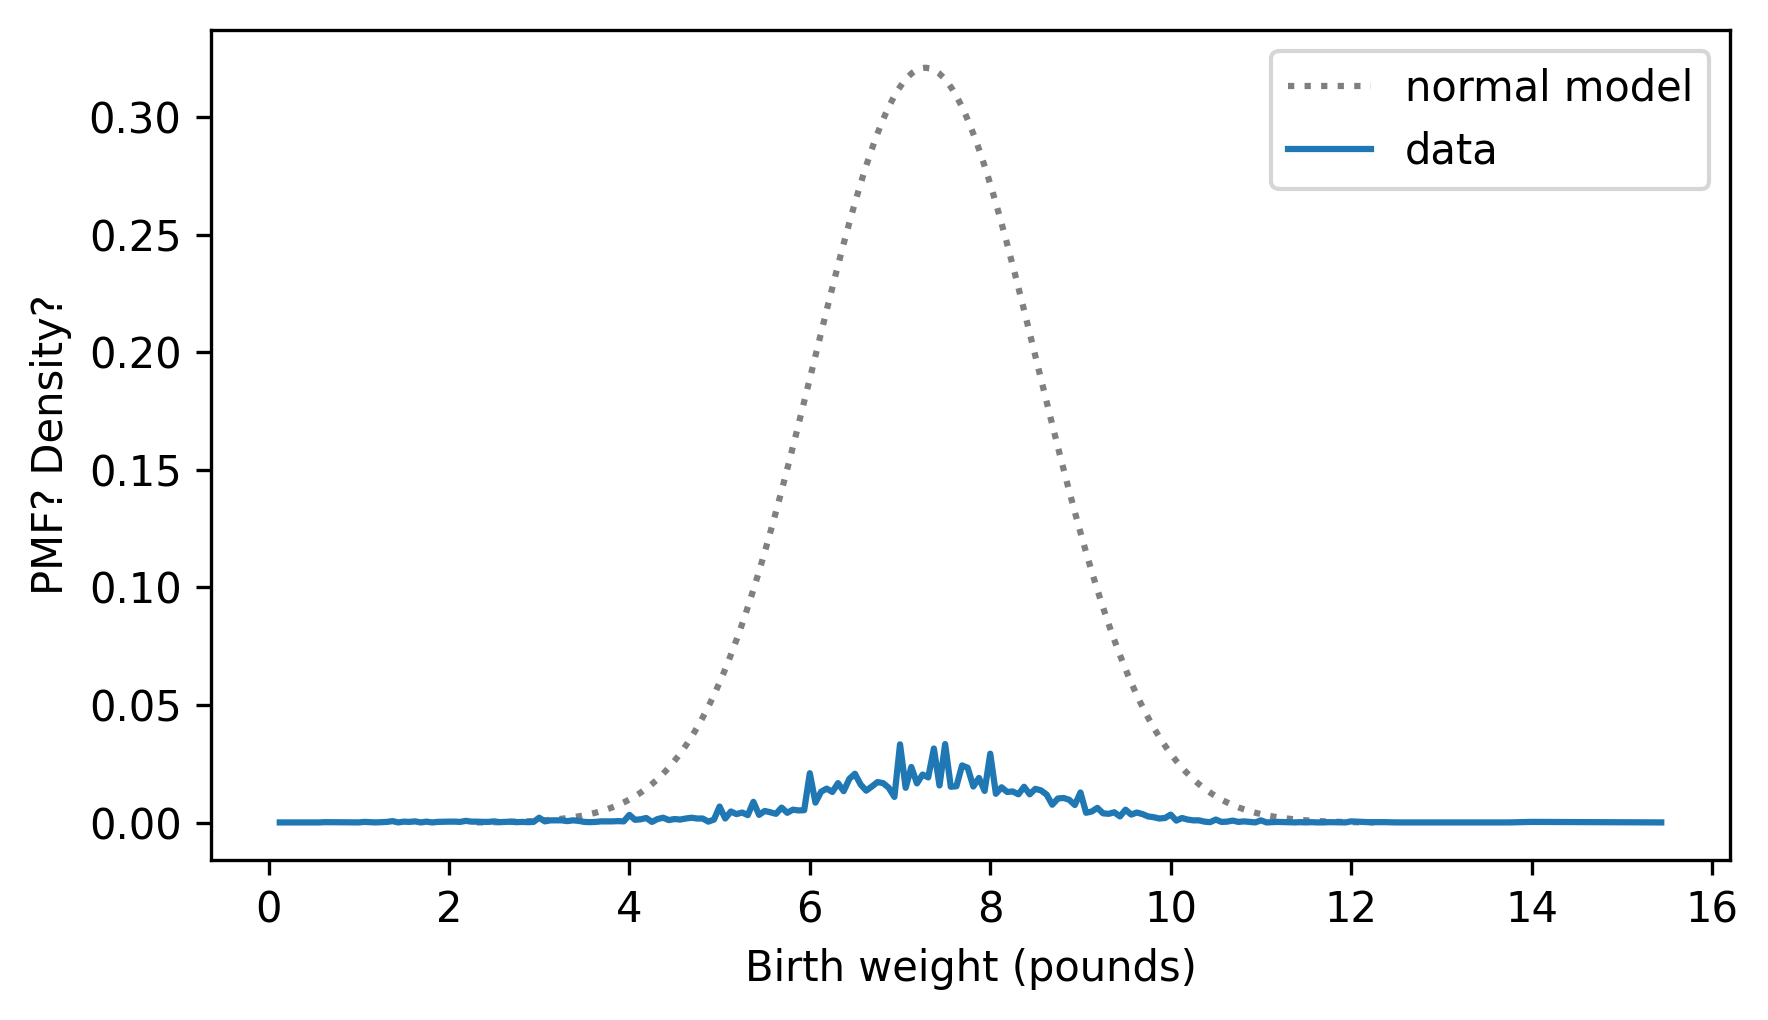

In [40]:
pdf_model.plot(ls=":", color="gray")
pmf_birth_weight.plot()

decorate(xlabel="Birth weight (pounds)", ylabel="PMF? Density?")

It doesn't work very well.
One reason is that they are not in the same units.
A PMF contains probability masses and a PDF contains probability densities, so we can't compare them, and we shouldn't plot them on the same axes.

As a first attempt to solve the problem, we can make a `Pmf` that approximates the normal distribution by evaluating the PDF at a discrete set of points.
`NormalPdf` provides a `make_pmf` method that does that.

In [41]:
pmf_model = pdf_model.make_pmf()

The result is a normalized `Pmf` that contains probability masses, so we can at least plot it on the same axes as the PMF of the data.

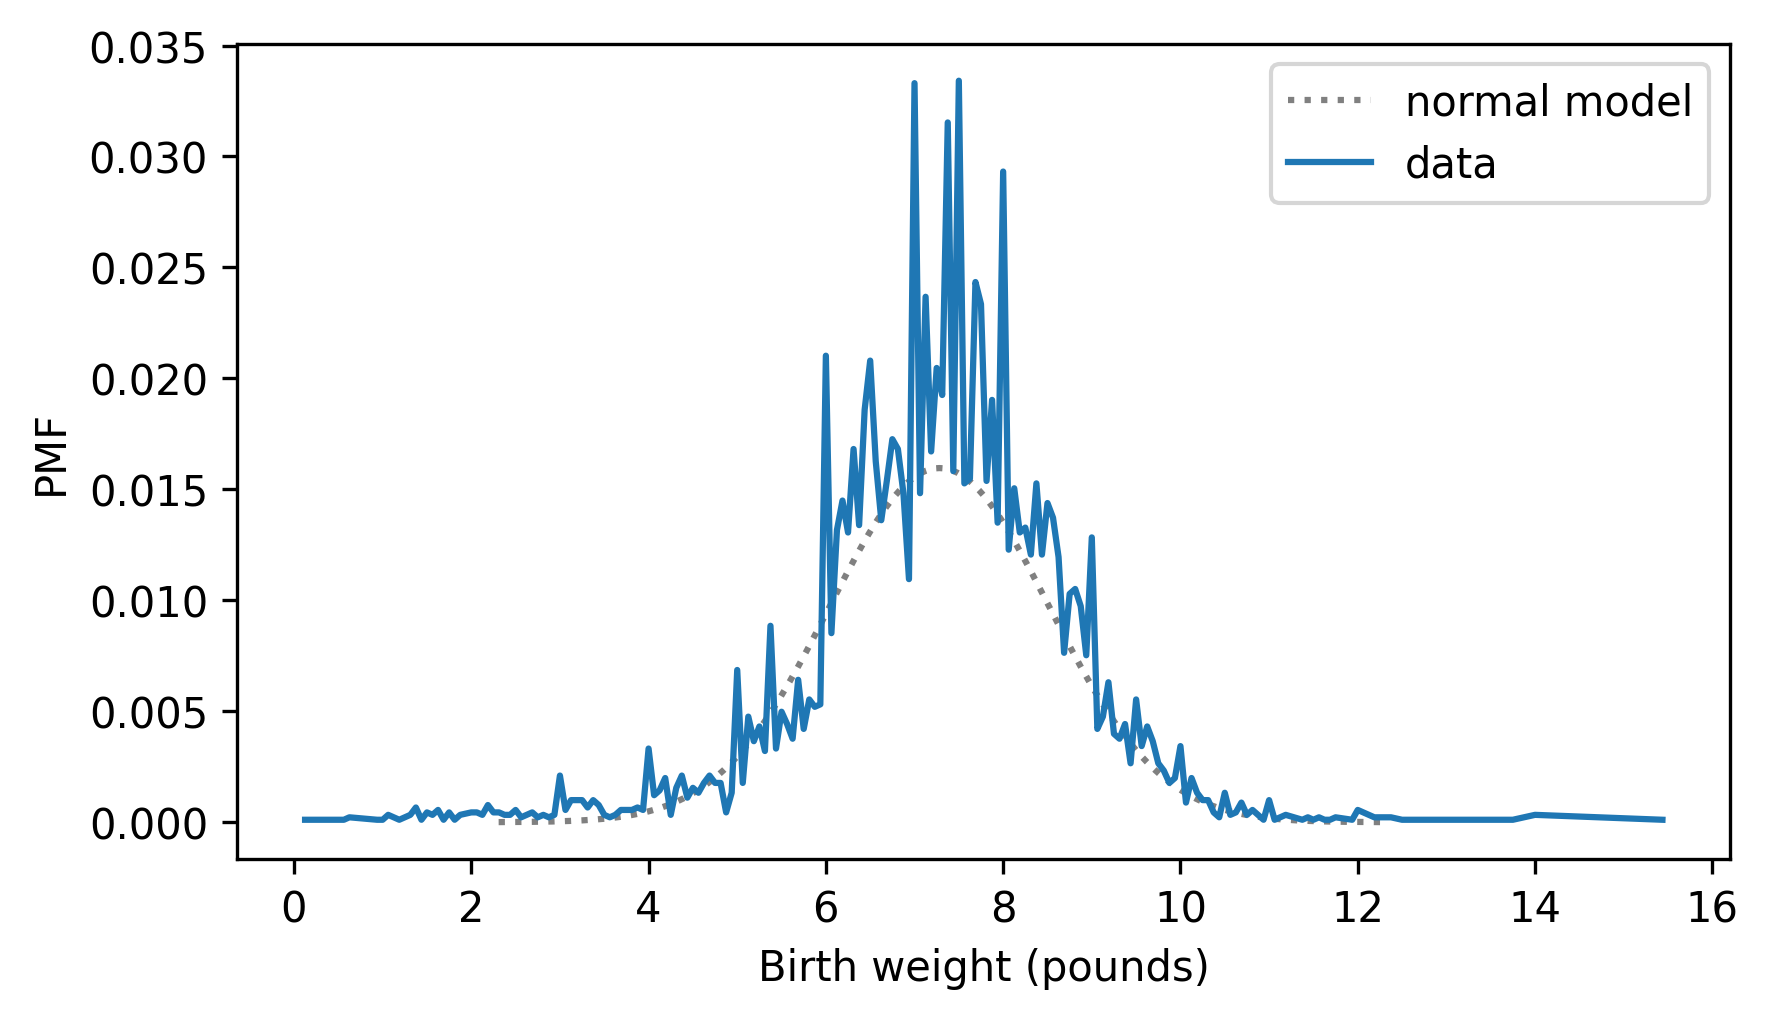

In [42]:
pmf_model.plot(ls=":", color="gray")
pmf_birth_weight.plot()

decorate(xlabel="Birth weight (pounds)", ylabel="PMF")

But this is still not a good way to compare distributions.
One problem is that the two `Pmf` objects contain different numbers of quantities, and the quantities in `pmf_birth_weight` are not equally spaced, so the probability masses are not really comparable.

In [43]:
len(pmf_model), len(pmf_birth_weight)

(201, 184)

The other problem is that the `Pmf` of the data is noisy.
So let's try something else.

(section_kernel_density_estimation)=
## Kernel Density Estimation

Instead of using the model to make a PMF, we can use the data to make a PDF.
To show how that works, I'll start with a small sample of the data.

In [44]:
# Set the random seed so we get the same results every time
np.random.seed(3)

In [45]:
n = 10
sample = birth_weights.sample(n)

The `Pmf` of this sample looks like this.

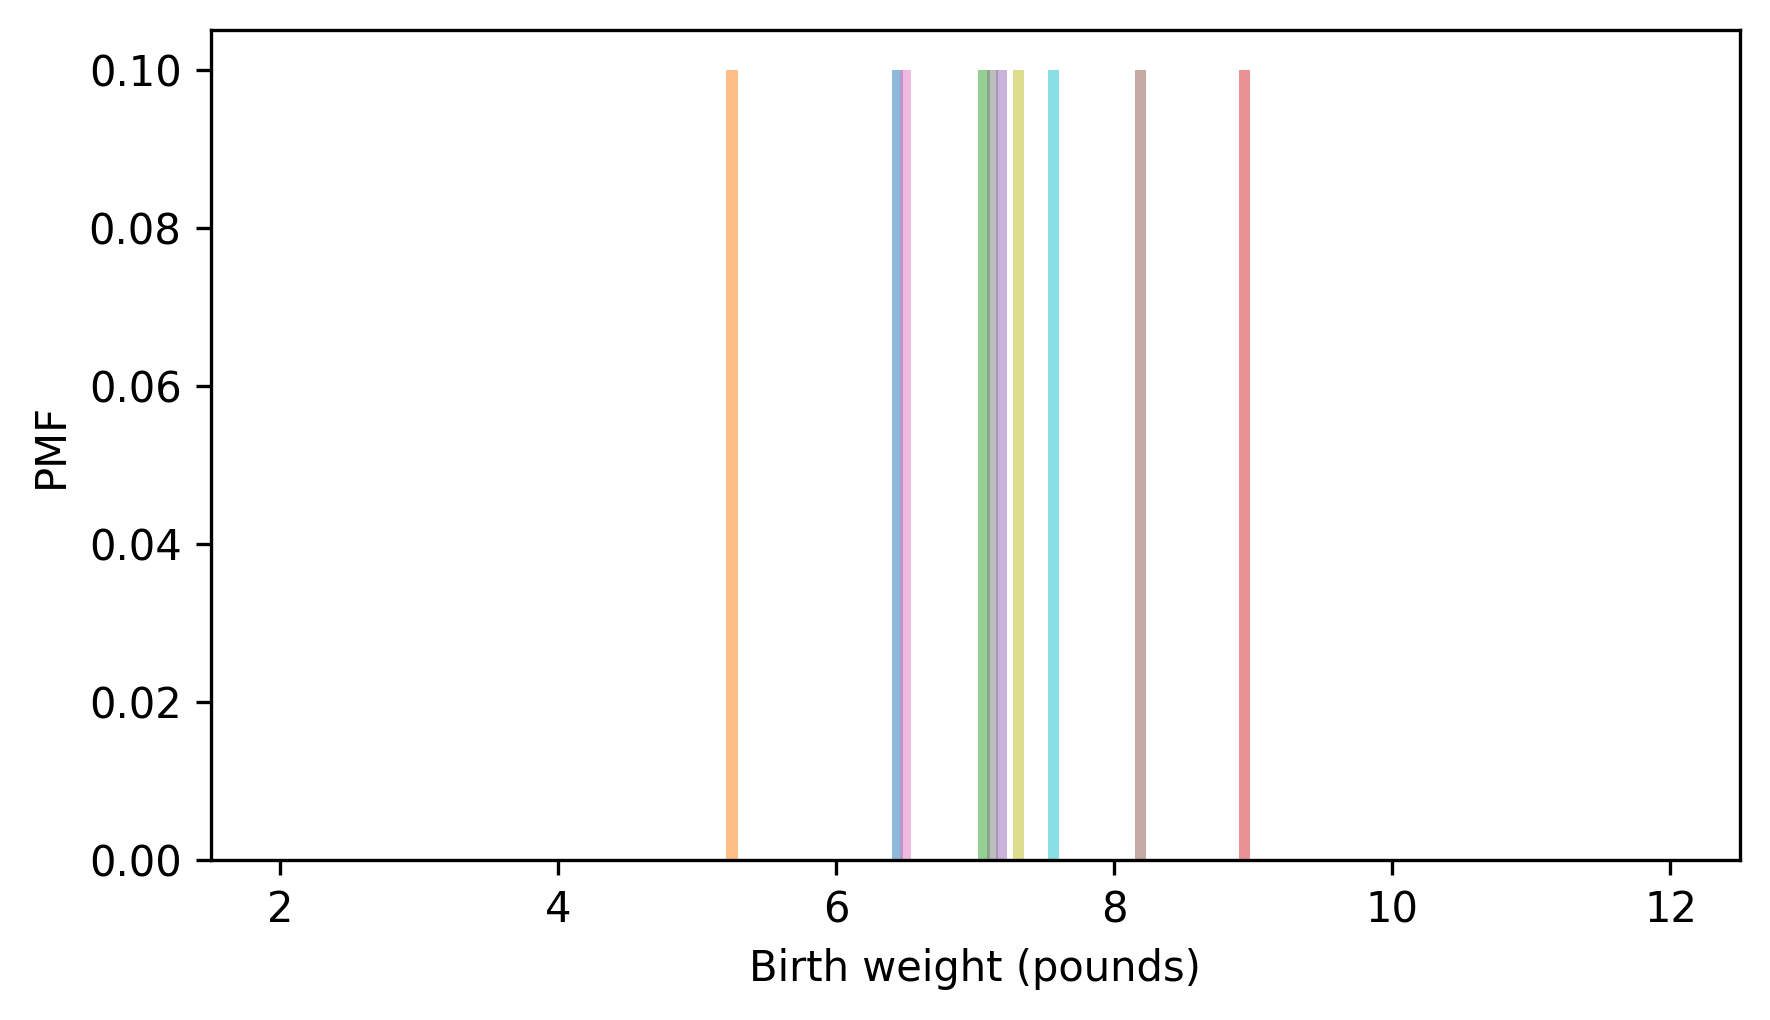

In [46]:
for weight in sample:
    pmf = Pmf.from_seq([weight]) / n
    pmf.bar(width=0.08, alpha=0.5)

xlim = [1.5, 12.5]
decorate(xlabel="Birth weight (pounds)", ylabel="PMF", xlim=xlim)

This way of representing the distribution treats the data as if it is discrete, so each probability mass is stacked up on a single point.
But birth weight is actually continuous, so the quantities between the measurements are also possible.
We can represent that possibility by replacing each discrete probability mass with a continuous probability density, like this.

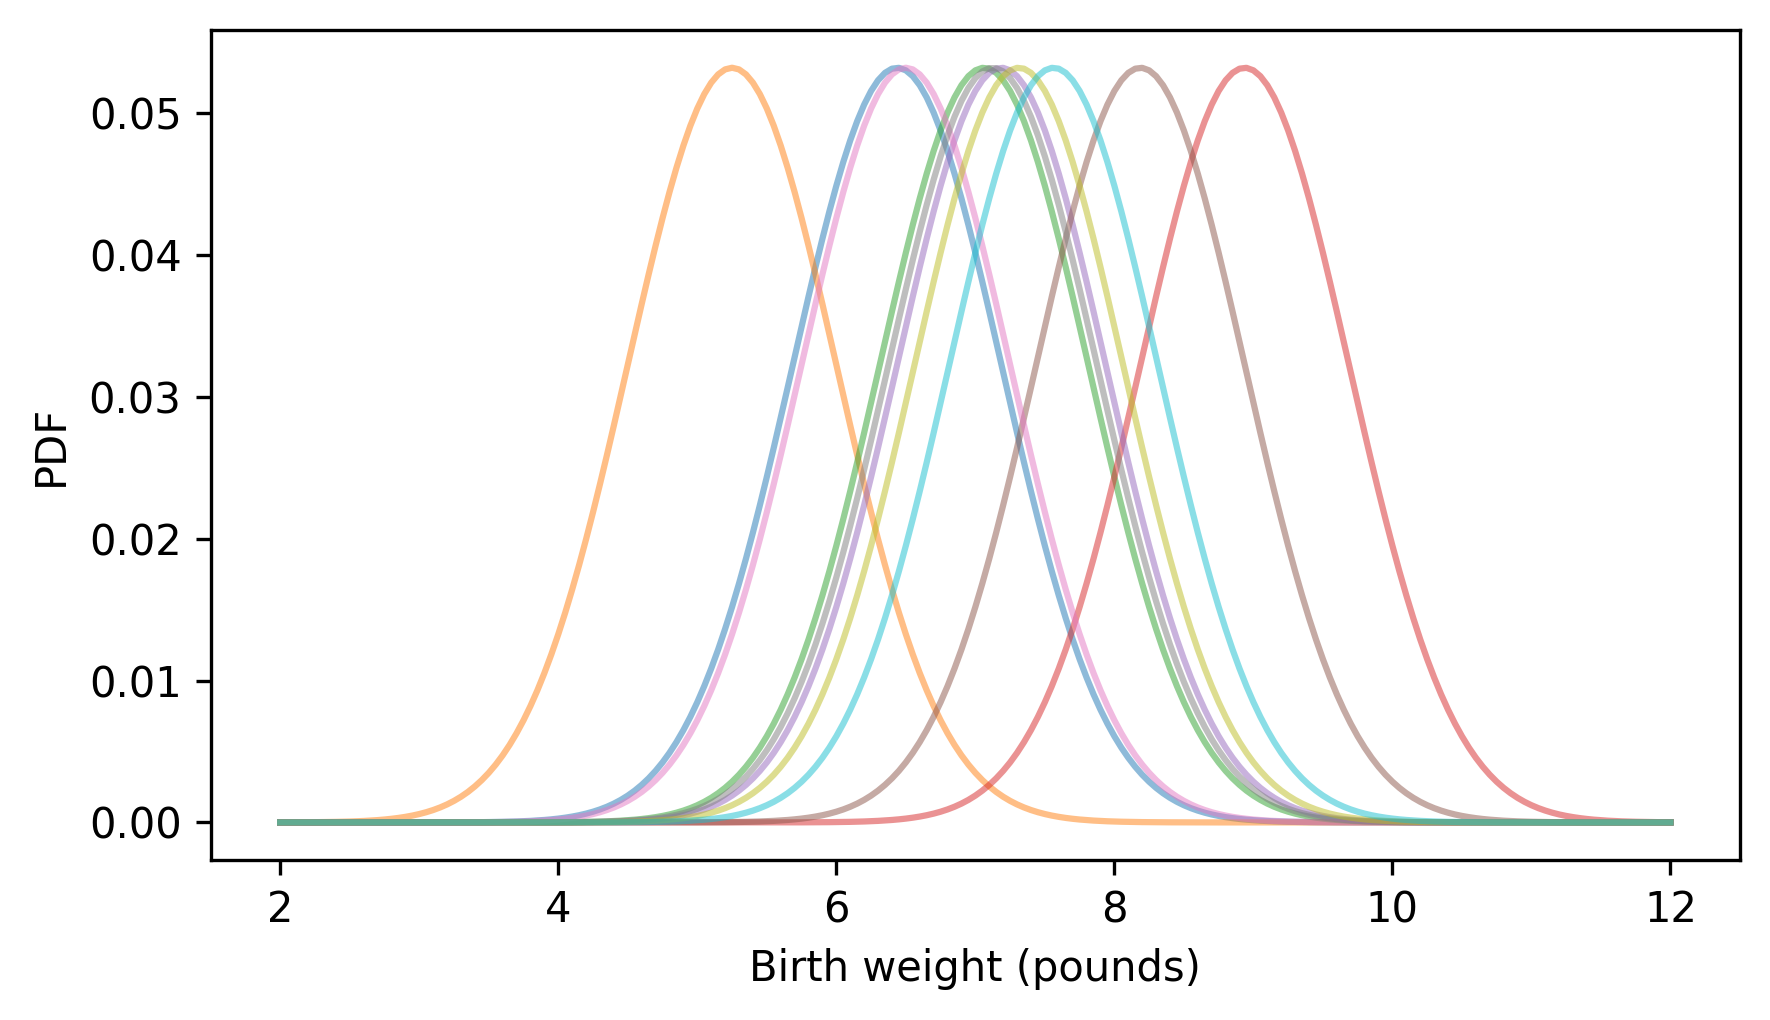

In [47]:
qs = np.linspace(2, 12, 201)

for weight in sample:
    ps = NormalPdf(weight, 0.75)(qs) / n
    plt.plot(qs, ps, alpha=0.5)

decorate(xlabel="Birth weight (pounds)", ylabel="PDF", xlim=xlim)

For each weight in the sample, we create a `NormalPdf` with the observed weight as the mean -- now let's add them up.

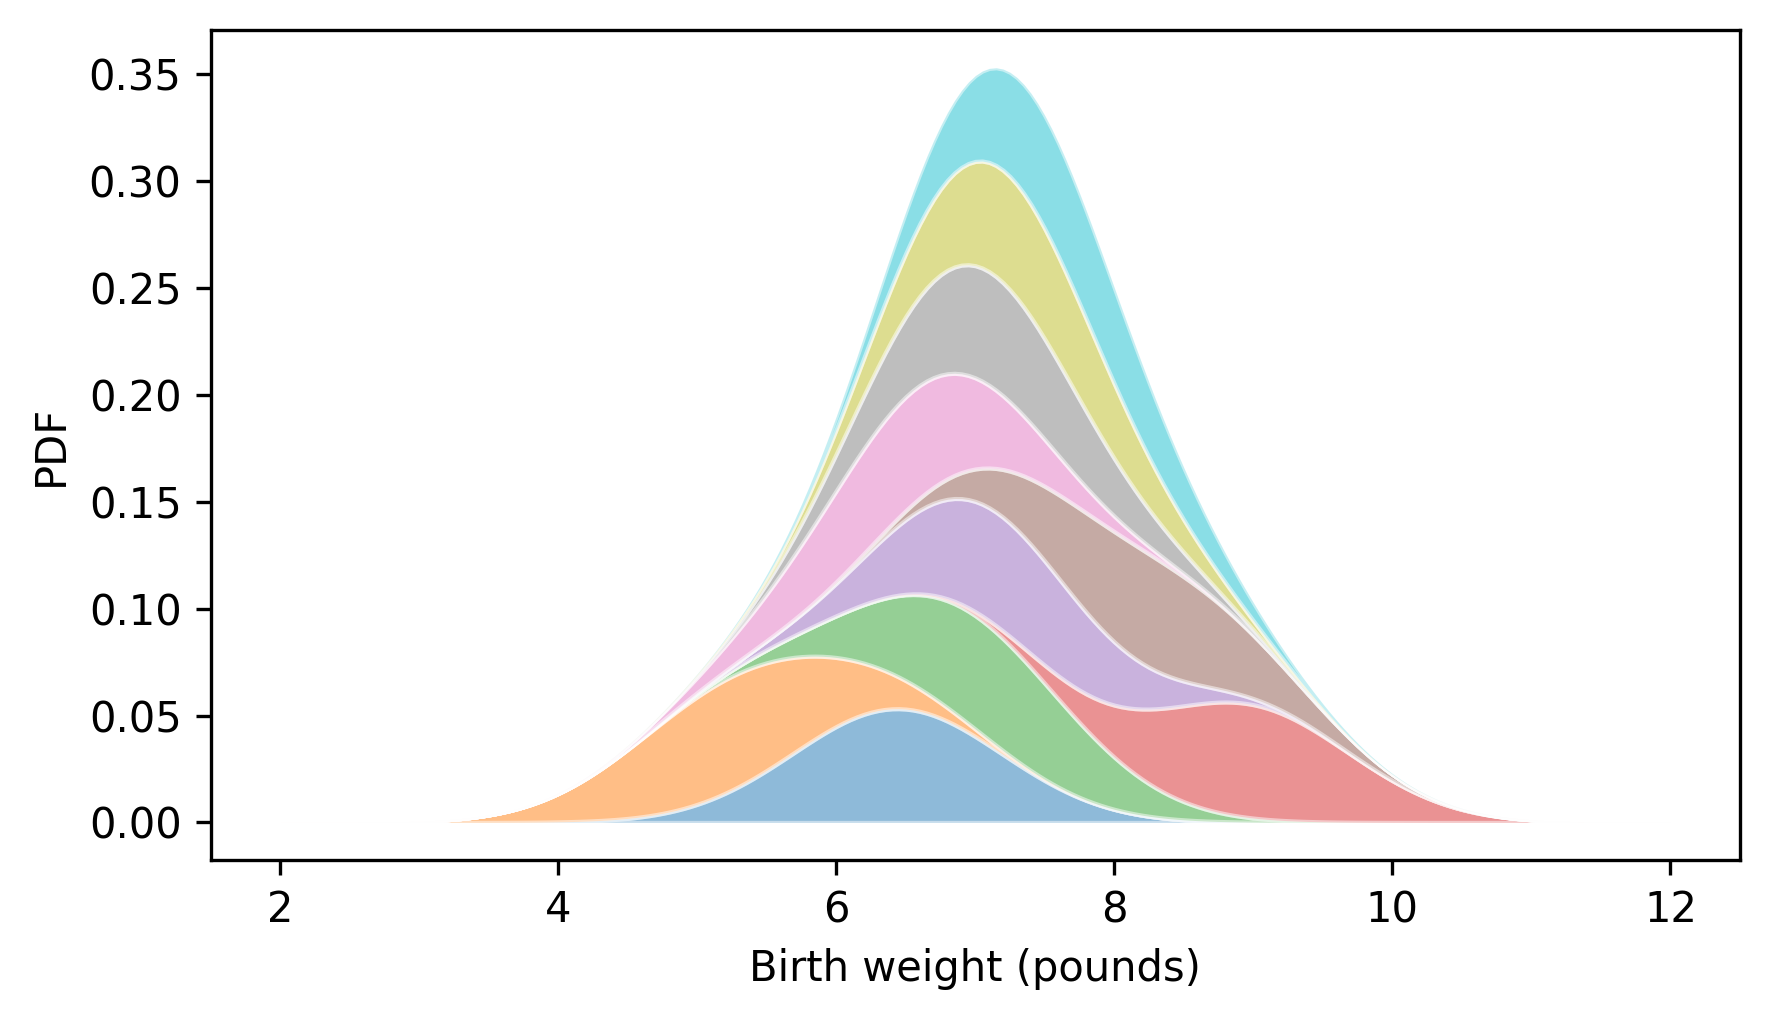

In [48]:
low_ps = np.zeros_like(qs)

for weight in sample:
    ps = NormalPdf(weight, 0.75)(qs) / n
    high_ps = low_ps + ps
    plt.fill_between(qs, low_ps, high_ps, alpha=0.5, lw=1, ec="white")
    low_ps = high_ps

decorate(xlabel="Birth weight (pounds)", ylabel="PDF", xlim=xlim)

When we add up the probability densities for each data point, the result is an estimate of the probability density for the whole sample.
This process is called **kernel density estimation** or KDE.
In this context, a "kernel" is one of the small density functions we added up.
Because the kernels we used are normal distributions -- also known as Gaussians -- we could say more specifically that we computed a Gaussian KDE.

SciPy provides a function called `gaussian_kde` that implements this algorithm.
Here's how we can use it to estimate the distribution of birth weights.

In [49]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(birth_weights)

The result is an object that represents the estimated PDF, which we can evaluate by calling it like  a function.

In [50]:
ps = kde(qs)

Here's what the result looks like.

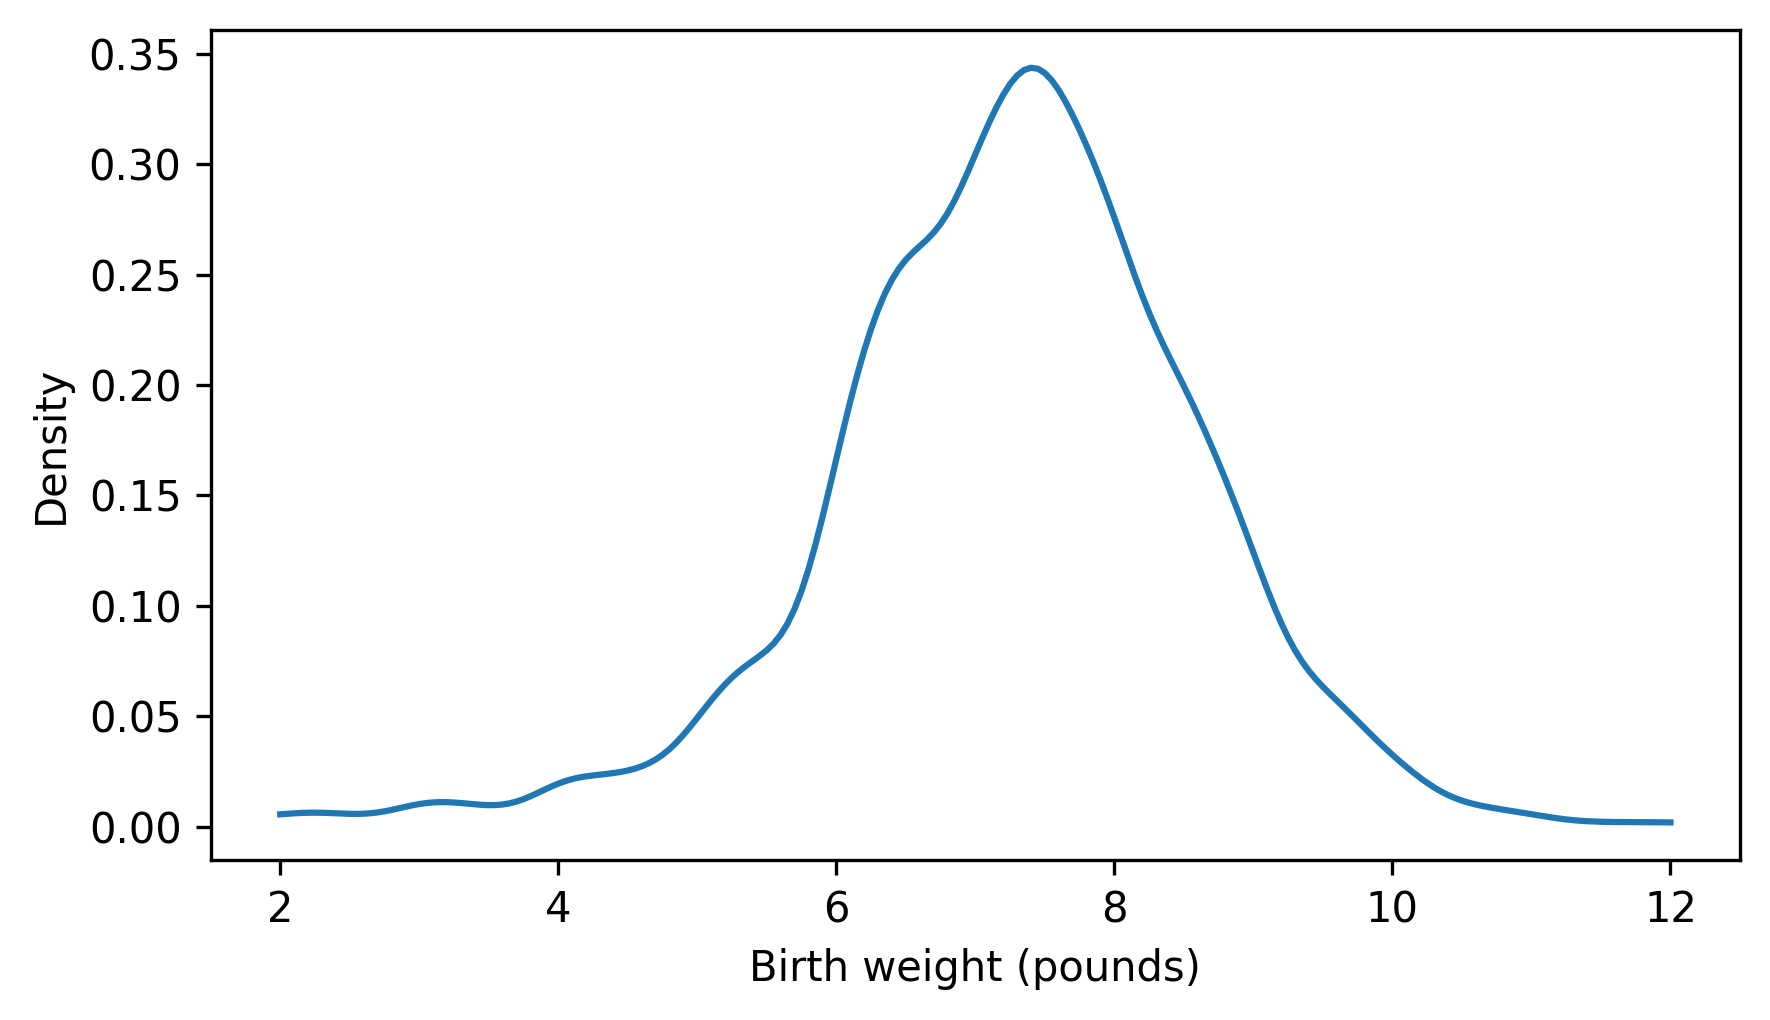

In [51]:
plt.plot(qs, ps)

decorate(xlabel="Birth weight (pounds)", ylabel="Density")

`thinkstats` provides a `Pdf` object that takes the result from `gaussian_kde`, and a domain that indicates where the density should be evaluated.
Here's how we make one.

In [52]:
from thinkstats import Pdf

domain = np.min(birth_weights), np.max(birth_weights)
kde_birth_weights = Pdf(kde, domain, name="data")

`Pdf` provides a `plot` method we can use to compare the estimated PDF of the sample to the PDF of a normal distribution.

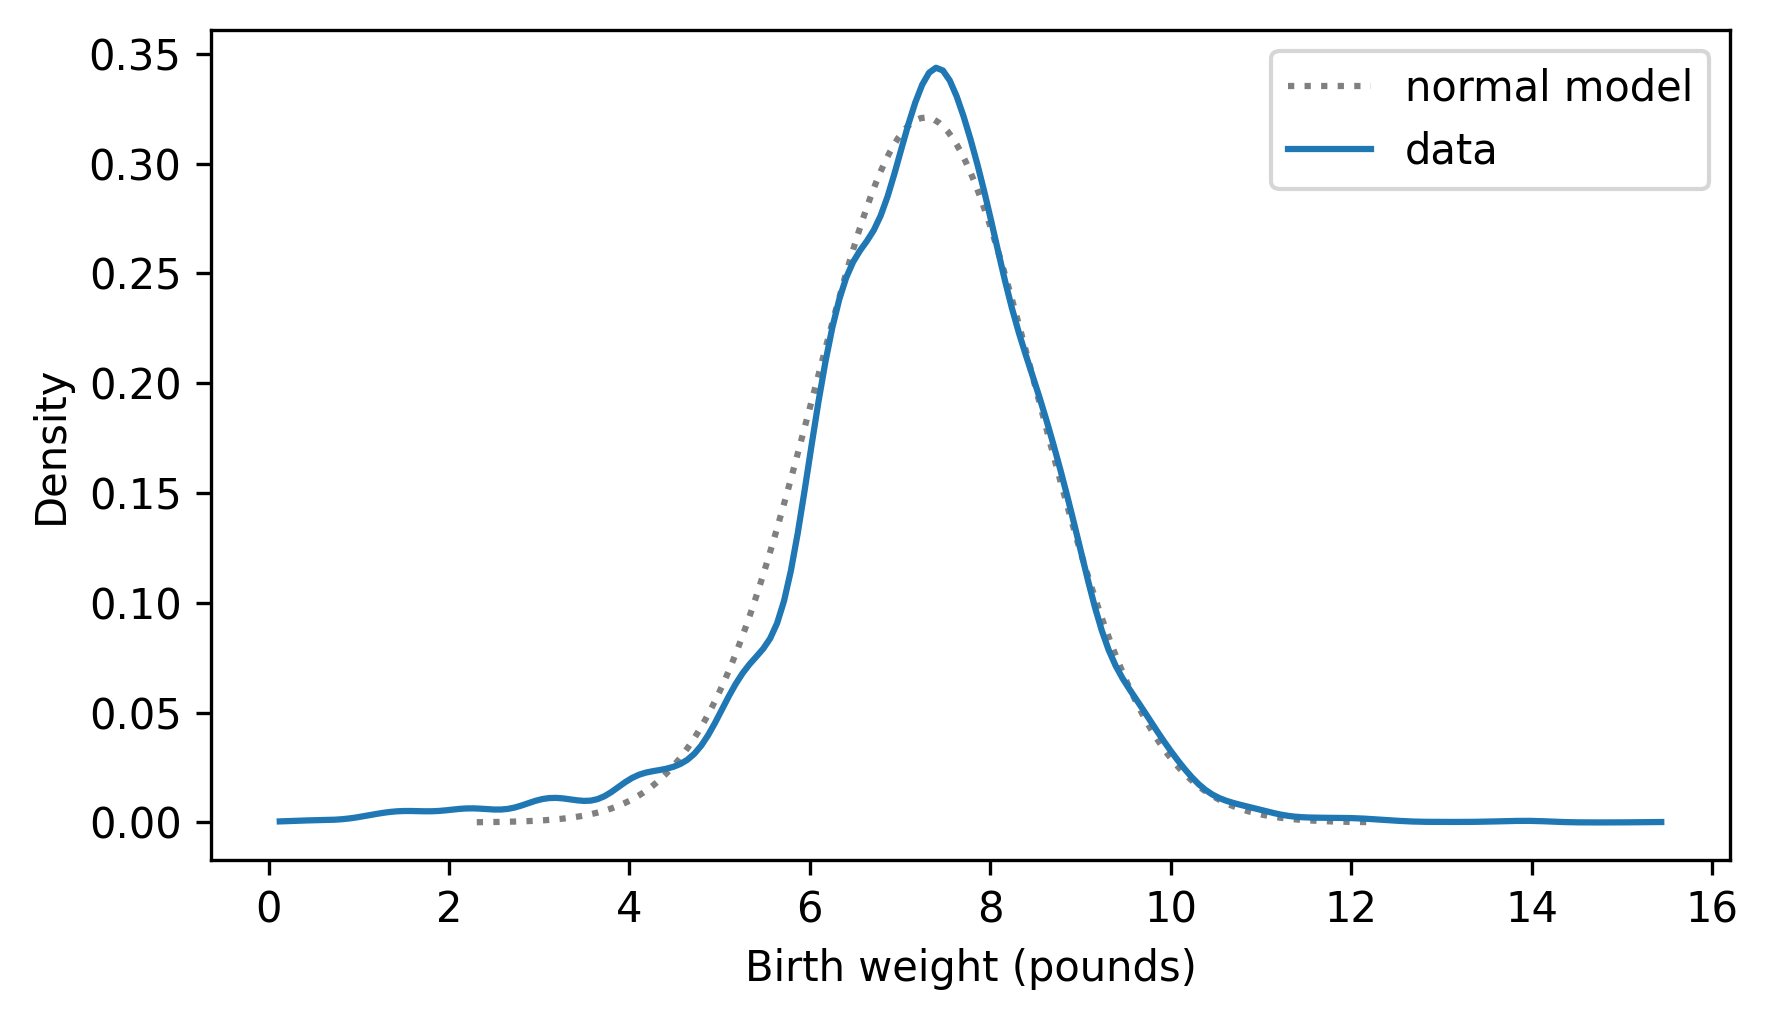

In [53]:
pdf_model.plot(ls=":", color="gray")
kde_birth_weights.plot()

decorate(xlabel="Birth weight (pounds)", ylabel="Density")

Kernel density estimation makes it possible to compare the distribution of a dataset to a theoretical model, and for some audiences, this is a good way to visualize the comparison.
But for audiences that are familiar with CDFs, comparing CDFs is often better.

## The Distribution Framework

At this point we have a complete set of ways to represent distributions: PMFs, CDFs, and PDFs
The following figure shows these representations and the transitions from one to another.
For example, if we have a `Pmf`, we can use the `cumsum` function to compute the cumulative sum of the probabilities and get a `Cdf` that represents the same distribution.

<img width="400" src="https://github.com/AllenDowney/ThinkStats/raw/v3/figs/distribution_framework.png">

To demonstrate these transitions, we'll use a new dataset that "contains the time of birth, sex, and birth weight for each of 44 babies born in one 24-hour period at a Brisbane, Australia, hospital," according to the description.
Instructions for downloading the data are in the notebook for this chapter.

According to the information in the file

> Source: Steele, S. (December 21, 1997), "Babies by the Dozen for Christmas:
24-Hour Baby Boom," _The Sunday Mail_ (Brisbane), p. 7.
>
> STORY BEHIND THE DATA:
Forty-four babies -- a new record -- were born in one 24-hour period at
the Mater Mothers' Hospital in Brisbane, Queensland, Australia, on
December 18, 1997.  For each of the 44 babies, _The Sunday Mail_
recorded the time of birth, the sex of the child, and the birth weight
in grams.
>
> Additional information about this dataset can be found in the "Datasets
and Stories" article "A Simple Dataset for Demonstrating Common
Distributions" in the _Journal of Statistics Education_ (Dunn 1999).
>
> Downloaded from <https://jse.amstat.org/datasets/babyboom.txt>

In [54]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/babyboom.dat")

Downloaded babyboom.dat


We can read the data like this.

In [55]:
from thinkstats import read_baby_boom

boom = read_baby_boom()
boom.head()

,time,sex,weight_g,minutes
0,5,1,3837,5
1,104,1,3334,64
2,118,2,3554,78
3,155,2,3838,115
4,257,2,3625,177


The `minutes` column records "the number of minutes since midnight for each birth".
So we can use the `diff` method to compute the interval between each successive birth.

In [56]:
diffs = boom["minutes"].diff().dropna()

If births happen with equal probability during any minute of the day, we expect these intervals to follow an exponential distribution.
In reality, that assumption is not precisely true, but the exponential distribution might still be a good model for the data.

To find out, we'll start by making a `Pmf` that represents the distribution of intervals.

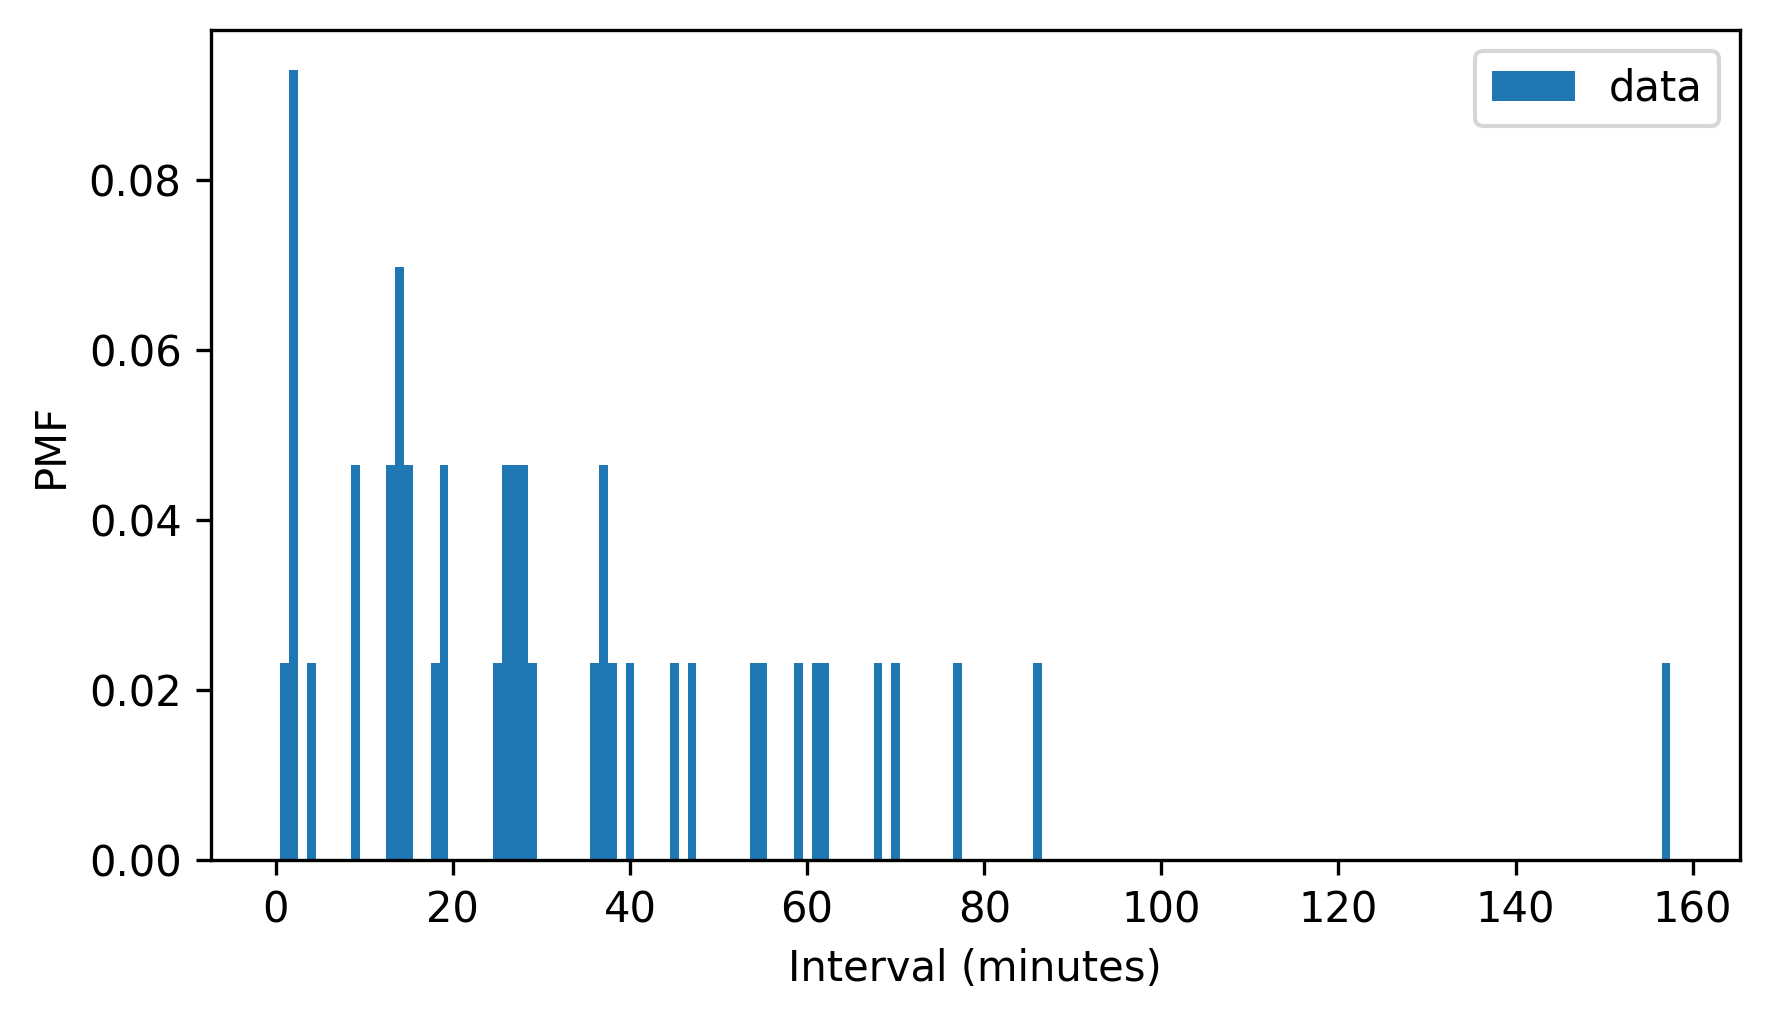

In [57]:
pmf_diffs = Pmf.from_seq(diffs, name="data")
pmf_diffs.bar(width=1)

decorate(xlabel="Interval (minutes)", ylabel="PMF")

Then we can use `make_cdf` to compute the cumulative probabilities and store them in a `Cdf` object.

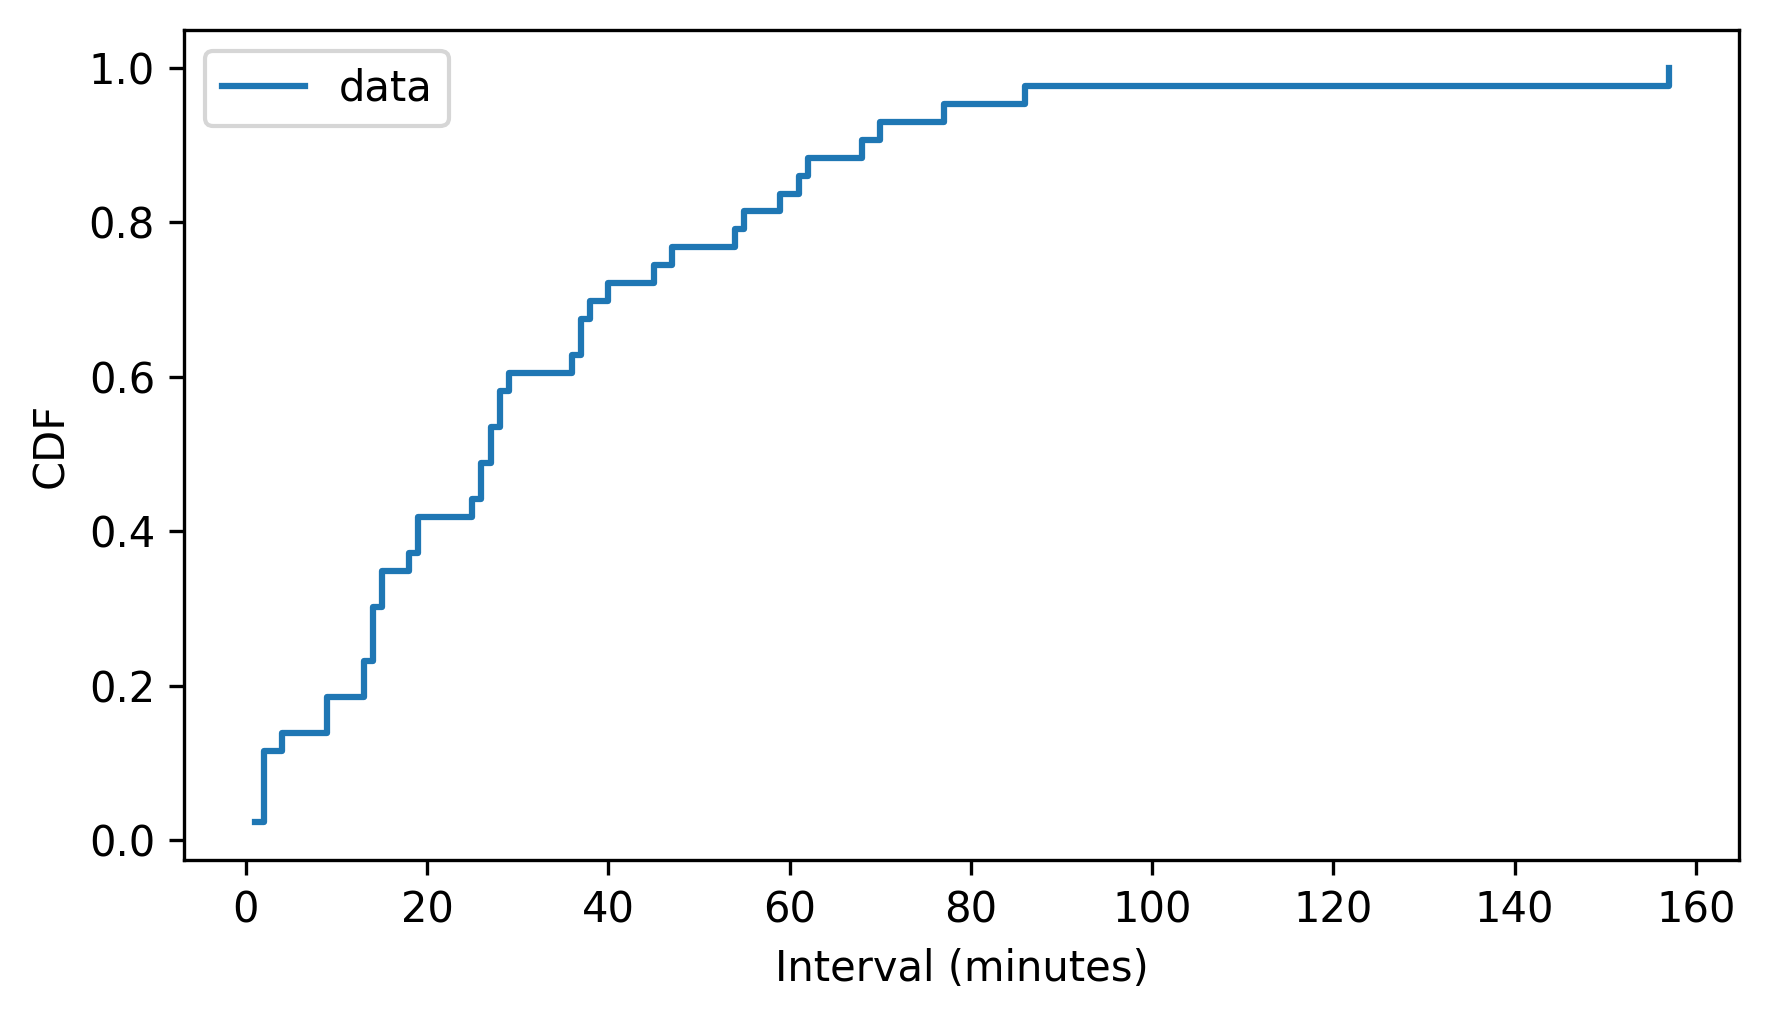

In [58]:
cdf_diffs = pmf_diffs.make_cdf()
cdf_diffs.step()

decorate(xlabel="Interval (minutes)", ylabel="CDF")

The `Pmf` and `Cdf` are equivalent in the sense that if we are given either one, we can compute the other.
To demonstrate, we'll use the `make_pmf` method, which computes the differences between successive probabilities in a `Cdf` and returns a `Pmf`.

In [59]:
pmf_diffs2 = cdf_diffs.make_pmf()

The result should be identical to the original `Pmf`, but there might be small floating-point errors.
We can use `allclose` to check that the result is close to the original `Pmf`.

In [60]:
np.allclose(pmf_diffs, pmf_diffs2)

True

And it is.

From a `Pmf`, we can estimate a density function by calling `gaussian_kde` with the probabilities from the `Pmf` as weights.

In [61]:
kde = gaussian_kde(pmf_diffs.qs, weights=pmf_diffs.ps)

To plot the results, we can use `kde` to make a `Pdf` object, and call the `plot` method.

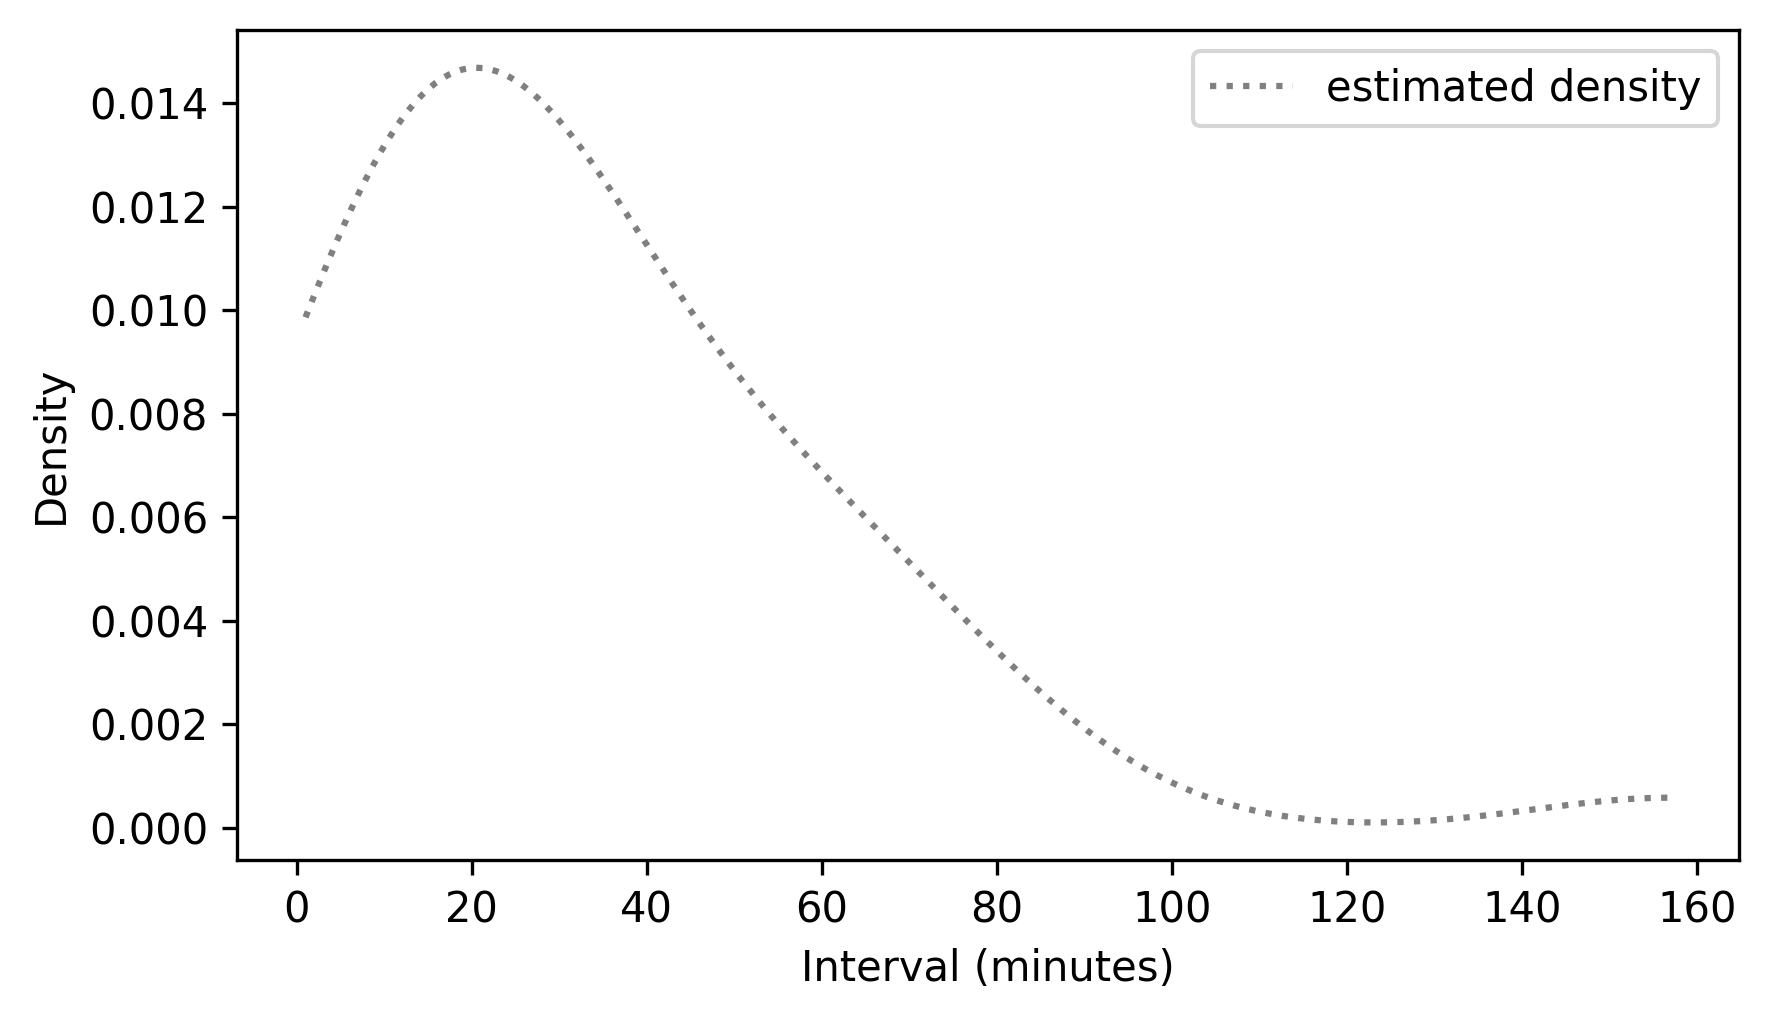

In [62]:
domain = np.min(pmf_diffs.qs), np.max(pmf_diffs.qs)
kde_diffs = Pdf(kde, domain=domain, name="estimated density")

kde_diffs.plot(ls=":", color="gray")
decorate(xlabel="Interval (minutes)", ylabel="Density")

To see whether the estimated density follows an exponential model, we can make an `ExponentialCdf` with the same mean as the data.

In [63]:
from thinkstats import ExponentialCdf

m = diffs.mean()
lam = 1 / m
cdf_model = ExponentialCdf(lam, name="exponential CDF")

Here’s what it looks like compared to the CDF of the data.

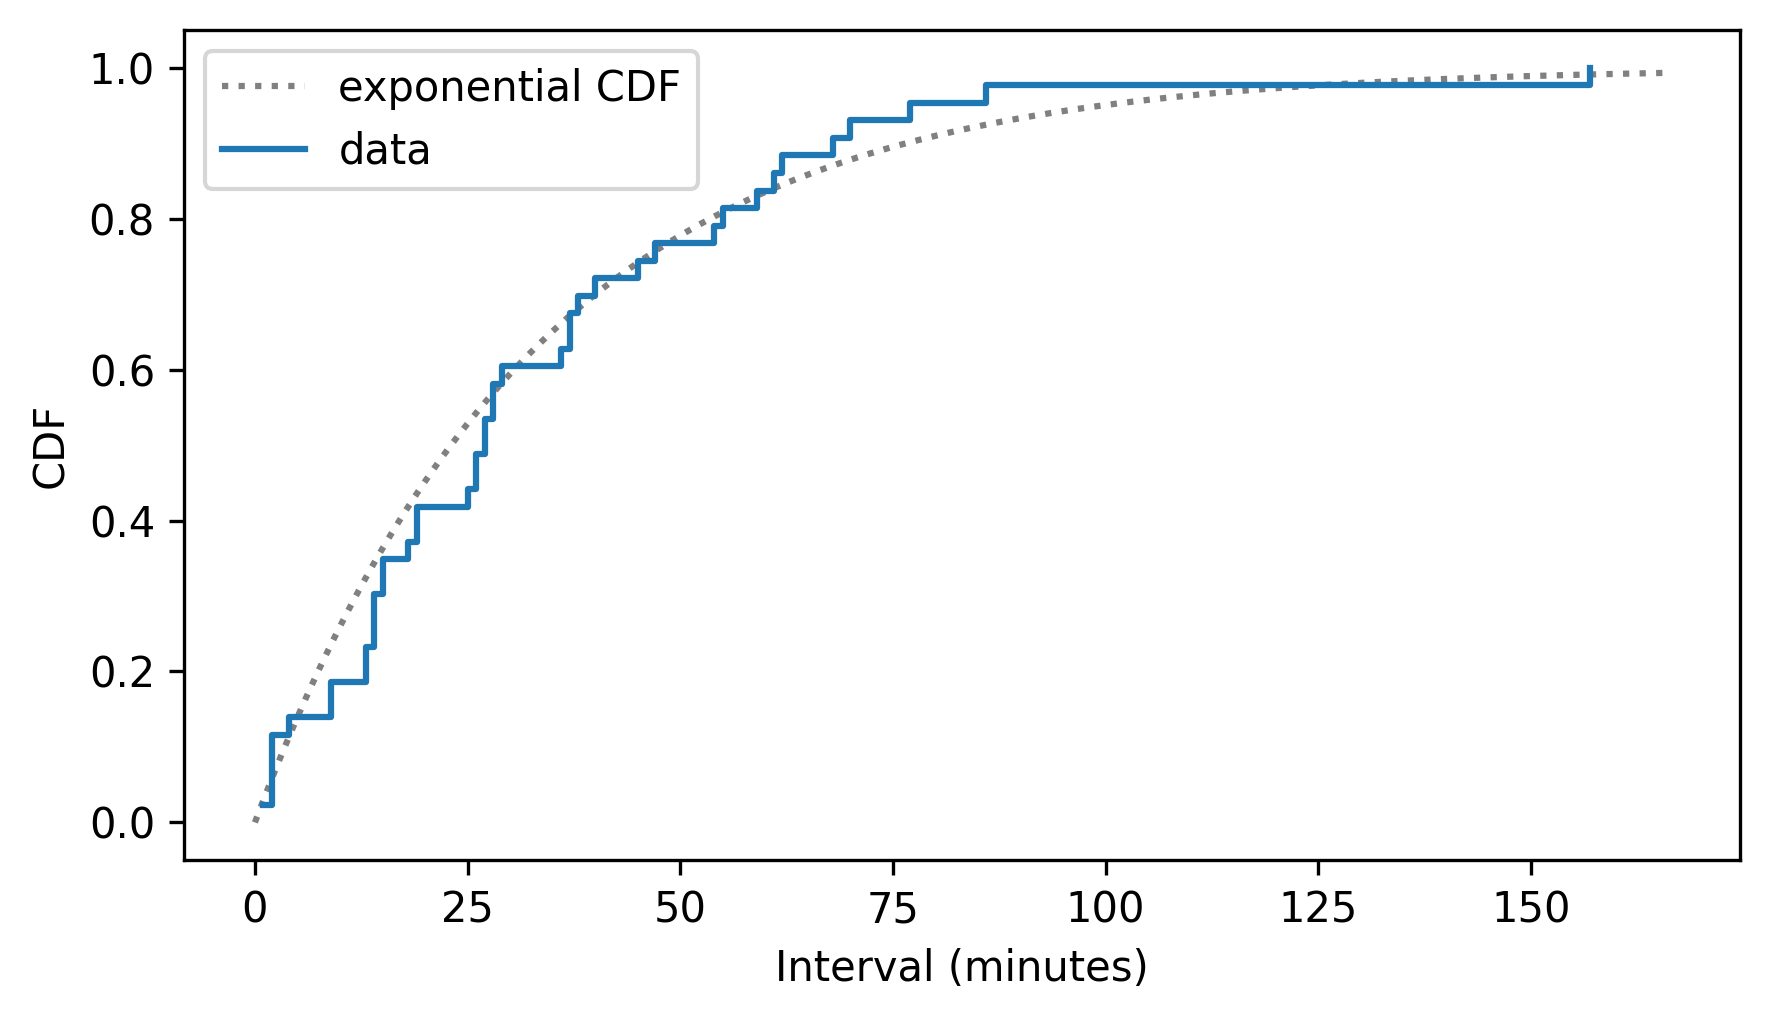

In [64]:
cdf_model.plot(ls=":", color="gray")
cdf_diffs.step()

decorate(xlabel="Interval (minutes)", ylabel="CDF")

The exponential model fits the CDF of the data well.

Given an `ExponentialCdf`, we can use `make_cdf` to **discretize** the CDF -- that is, to make a discrete approximation by evaluating the CDF at a sequence of equally spaced quantities.

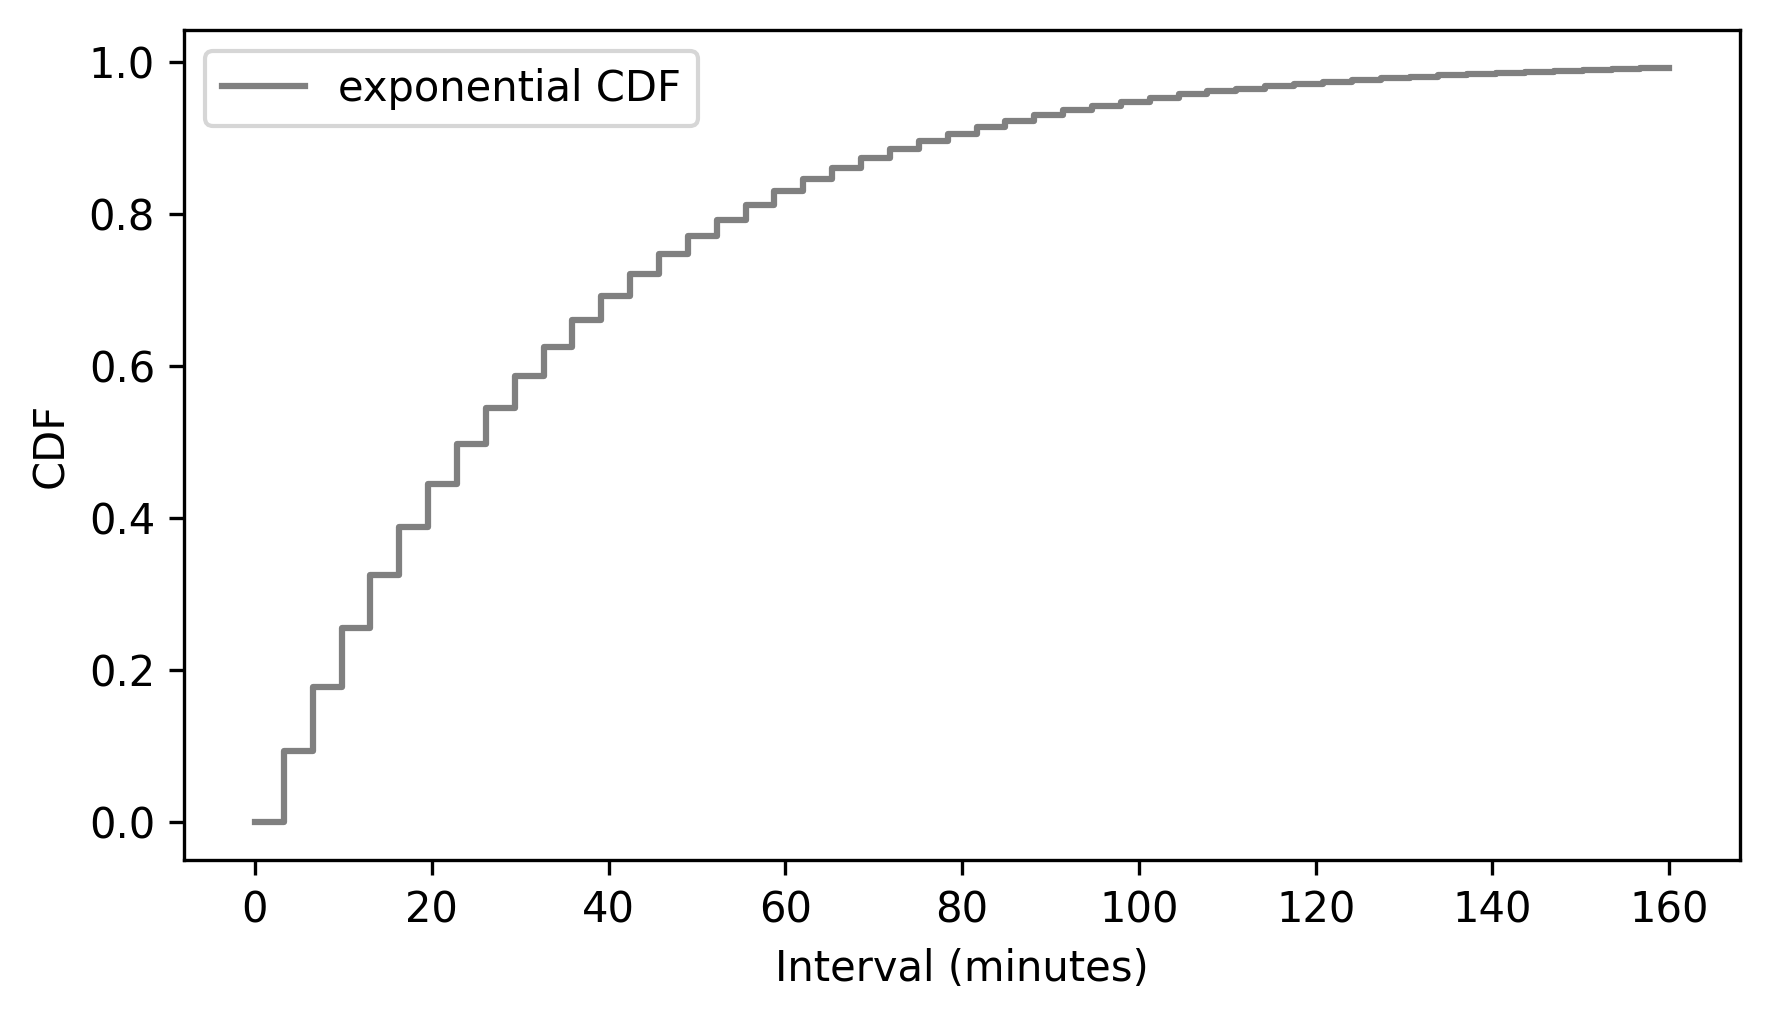

In [65]:
qs = np.linspace(0, 160)
discrete_cdf_model = cdf_model.make_cdf(qs)
discrete_cdf_model.step(color="gray")

decorate(xlabel="Interval (minutes)", ylabel="CDF")

Finally, to get from a discrete CDF to a continuous CDF, we can interpolate between the steps, which is what we see if we use the `plot` method instead of the `step` method.

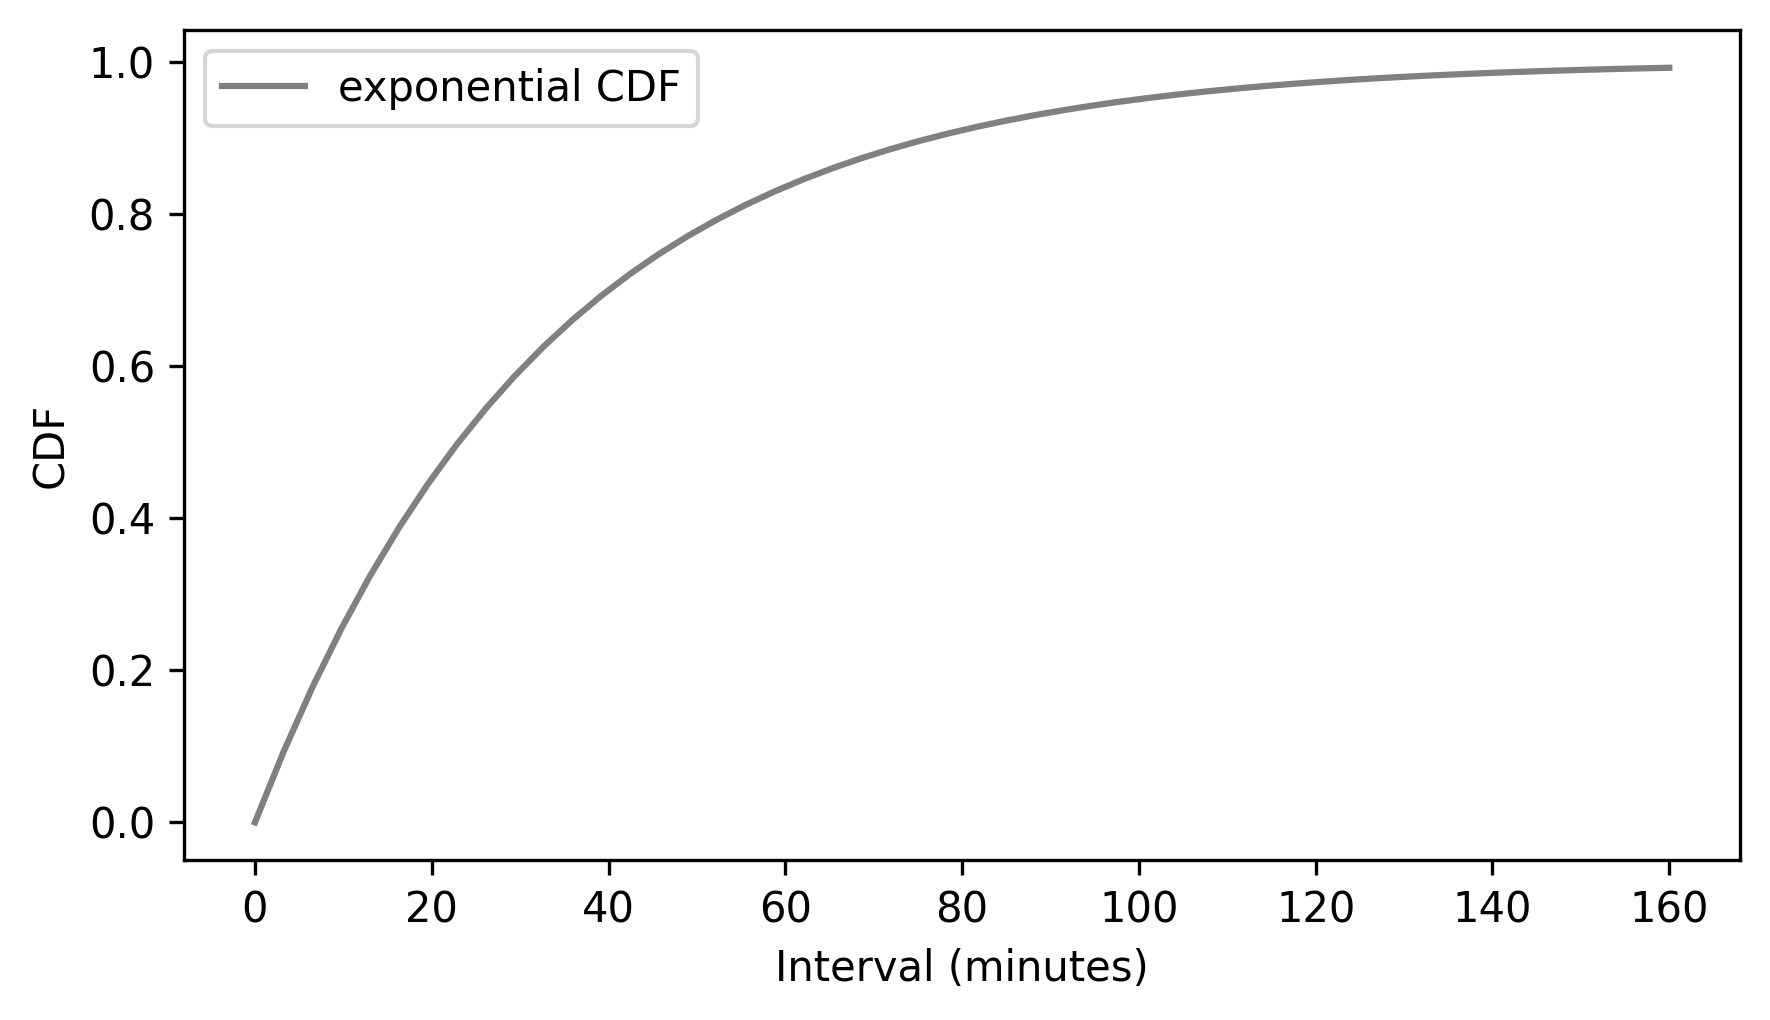

In [66]:
discrete_cdf_model.plot(color="gray")

decorate(xlabel="Interval (minutes)", ylabel="CDF")

Finally, a PDF is the derivative of a continuous CDF, and a CDF is the integral of a PDF.

To demonstrate, we can use SymPy to define the CDF of an exponential distribution and compute its derivative.

In [67]:
import sympy as sp

x = sp.Symbol("x", real=True, positive=True)
λ = sp.Symbol("λ", real=True, positive=True)

cdf = 1 - sp.exp(-λ * x)
cdf

1 - exp(-x*λ)

In [68]:
pdf = sp.diff(cdf, x)
pdf

λ*exp(-x*λ)

And if we integrate the result, we get the CDF back -- although we lose the constant of integration in the process.

In [69]:
sp.integrate(pdf, x)

-exp(-x*λ)

This example shows how we use `Pmf`, `Cdf`, and `Pdf` objects to represent PMFs, CDFs, and PDFs, and demonstrates the process for converting from each to the others.

## Glossary

-   **continuous:** A quantity is continuous if it can have any value in a range on the number line. Most things we measure in the world -- like weight, distance, and time -- are continuous.


-   **discrete:** A quantity is discrete if it can have a limited set of values, like integers or categories. Exact counts are discrete, as well as categorical variables.


-   **probability density function (PDF)**: A function that shows how density (not probability) is spread across the values of a continuous variable. The area under the PDF within an interval gives the probability that the variable falls in that interval range.


-   **probability density**: The value of a PDF at a specific point; it's not a probability itself, but it can be used to compute a probability.


-   **kernel density estimation (KDE)**: A method for estimating a PDF based on a sample.


-   **discretize**: To approximate a continuous quantity by dividing its range into discrete levels or categories.


## Exercises

### Exercise 6.1

In World Cup soccer (football), suppose the time until the first goal is well modeled by an exponential distribution with rate `lam=2.5` goals per game.
Make an `ExponentialPdf` to represent this distribution and use `area_under` to compute the probability that the time until the first goal is less than half of a game.
Then use an `ExponentialCdf` to compute the same probability and check that the results are consistent.

In [70]:
# Solution goes here
lam = 2.5
pdf_wcs = ExponentialPdf(lam, name="wcs exponentialpdf model")
area_under(pdf_wcs, 0, 1 / 30)

np.float64(0.07995558537067676)

In [71]:
# Solution goes here
exponential_cdf(1 / 30, lam)

np.float64(0.07995558537067671)

In [72]:
# Solution goes here

Use `ExponentialPdf` to compute the probability the first goal is scored in the second half of the game.
Then use an `ExponentialCdf` to compute the same probability and check that the results are consistent.

In [73]:
# Solution goes here
pdf_wcs = ExponentialPdf(lam, name="wcs exponentialpdf model")
area_under(pdf_wcs, 0, 1 / 60)

np.float64(0.04081054289086181)

In [74]:
# Solution goes here
exponential_cdf(1 / 60, lam)

np.float64(0.040810542890861834)

### Exercise 6.2

In order to join Blue Man Group, you have to be male between 5’10” and 6’1”, which is roughly 178 to 185 centimeters.
Let's see what fraction of the male adult population in the United States meets this requirement.

The heights of male participants in the BRFSS are well modeled by a normal distribution with mean 178 cm and standard deviation 7 cm.

In [75]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/CDBRFS08.ASC.gz")

Downloaded CDBRFS08.ASC.gz


In [76]:
from thinkstats import read_brfss

brfss = read_brfss()
male = brfss.query("sex == 1")
heights = male["htm3"].dropna()

In [77]:
from scipy.stats import trimboth

trimmed = trimboth(heights, 0.01)
m, s = np.mean(trimmed), np.std(trimmed)
m, s

(np.float64(178.10278947124948), np.float64(7.017054887136004))

Here's a `NormalCdf` object that represents a normal distribution with the same mean and standard deviation as the trimmed data.

In [78]:
from thinkstats import NormalCdf

cdf_normal_model = NormalCdf(m, s, name='normal model')

And here's how it compares to the CDF of the data.

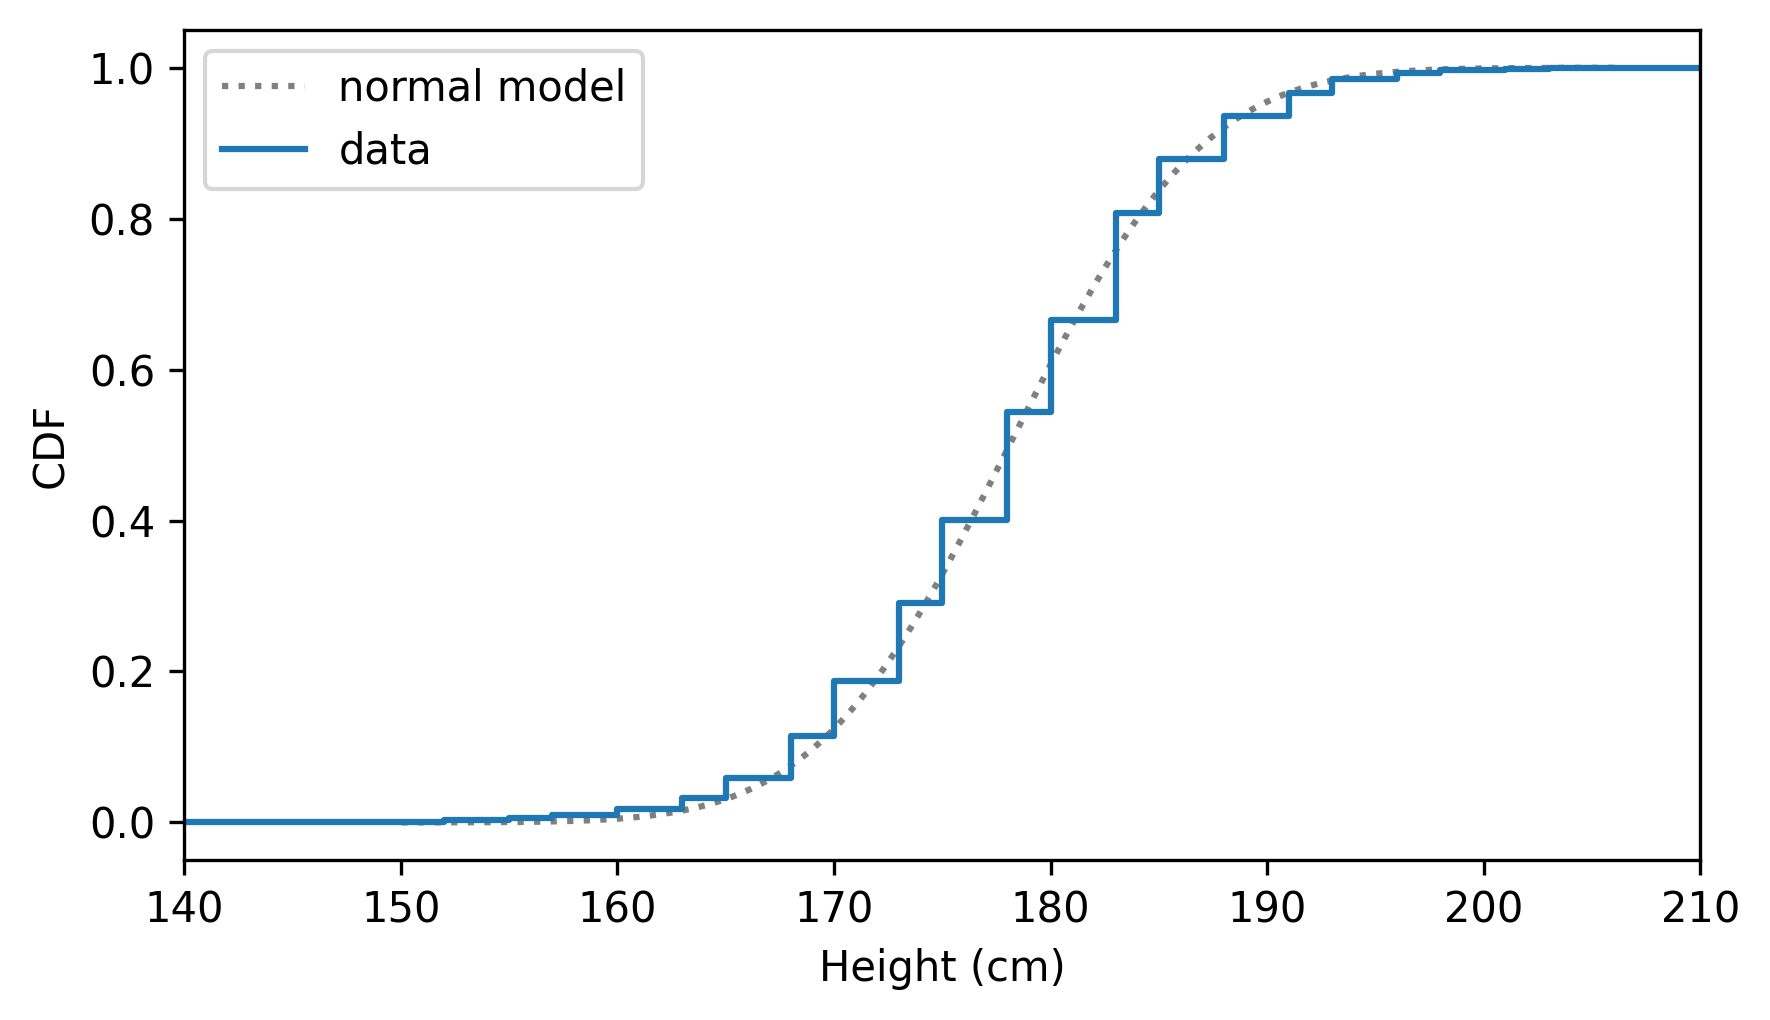

In [79]:
cdf_height = Cdf.from_seq(heights, name="data")
cdf_normal_model.plot(ls=":", color="gray")
cdf_height.step()

xlim = [140, 210]
decorate(xlabel="Height (cm)", ylabel="CDF", xlim=xlim)

Use `gaussian_kde` to make a `Pdf` that approximates the PDF of male height.
Hint: Investigate the `bw_method` argument, which can be used to control the smoothness of the estimated density.
Plot the estimated density and compare it to a `NormalPdf` with mean `m` and standard deviation `s`.

In [150]:
# Solution goes here
kde_mh = gaussian_kde(trimmed, bw_method=0.38)

domain_mh = np.min(trimmed), np.max(trimmed)
kde_mh_pdf = Pdf(kde_mh, domain_mh, name="mh data")
pdf_mh_normal_model = NormalPdf (m, s, name='pdf mh normal model')

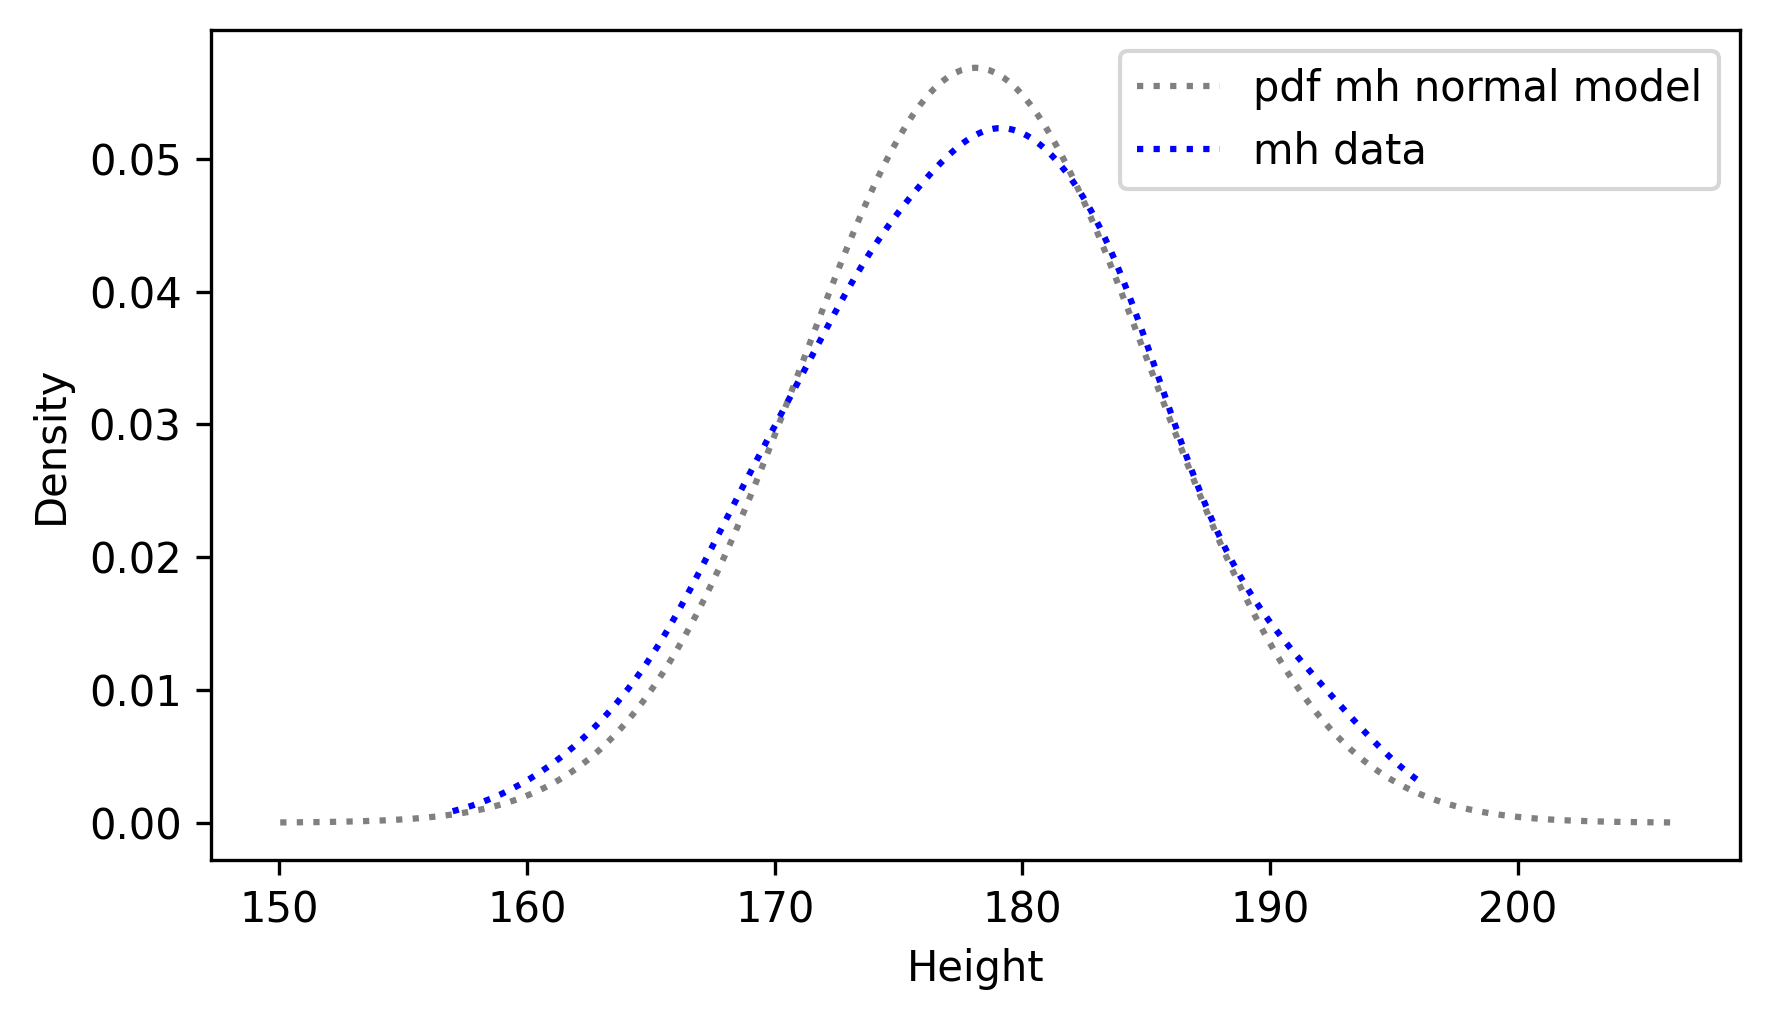

In [151]:
# Solution goes here
pdf_mh_normal_model.plot(ls=":", color="gray")

kde_mh_pdf.plot(ls=":", color="blue")

decorate(xlabel="Height", ylabel="Density")


In [ ]:
# Solution goes here


Use a `NormalPdf` and `area_under` to compute the fraction of people in the normal model that are between 178 and 185 centimeters.
Use a `NormalCdf` to compute the same fraction, and check that the results are consistent.
Finally, use the empirical `Cdf` of the data to see what fraction of people in the dataset are in the same range.

In [153]:
# Solution goes here
area_under(pdf_mh_normal_model, 178, 185)

np.float64(0.343020541679175)

In [161]:
# Solution goes here
cdf_mh_normal_model = make_normal_model(trimmed)
cdf_mh_normal_model(185) - cdf_mh_normal_model(178)


np.float64(0.3466275795521834)

In [160]:
# Solution goes here
Emp_mh_cdf = Cdf.from_seq(trimmed)
Emp_mh_cdf(185) - Emp_mh_cdf(178)

# All pretty close

np.float64(0.3423165630224889)

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)